# Week 4 - Counting Words & Phrases

This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora. 

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:


In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud_2020 #pip install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from the Davies set purchased for this class and developed by a computational linguist at Brigham Young University. We can get a list of works available from the [corpora here](https://www.english-corpora.org/).

In this notebook, I will be accessing the data locally - you also have access to this data through the Dropbox download link. The same code can be modified slighlty to access the rest of the corpora on RCC. 
There is a notebook describing this process in the same repository, as well as in the same directory on RCC.

In [2]:
corpus_name = "../Davies_Corpora/Movies"
# corpus_name = "Movies"

This method extracts the text from the zip files and stroes the raw data.

In [3]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file and not file.startswith('._'): # Ignore the files generated during the extracting process starting with '._'
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

In [4]:
movie_raw = loadcorpus(corpus_name)

text_11_uoy.zip
text_02_mqu.zip
text_08_loh.zip
text_00_myn.zip
text_12_rcq.zip
text_06_jfy.zip
text_20_cde.zip
text_10_aoy.zip
text_16_qll.zip
text_23_fmh.zip
text_09_oii.zip
text_25_byg.zip
text_15_guo.zip
text_18_jfj.zip
text_19_gvc.zip
text_17_arp.zip
text_13_idi.zip
text_24_ywo.zip
text_33_kje.zip
text_21_fqa.zip
text_28_rfy.zip
text_30_wkp.zip
text_03_mnq.zip
text_04_mlq.zip
text_29_oye.zip
text_14_lnc.zip
text_07_oma.zip
text_01_ote.zip
text_31_akv.zip
text_05_nko.zip
text_22_etp.zip
text_26_ngj.zip
text_32_ldf.zip
text_27_fle.zip


In [5]:
movie_raw['11.txt'][0:3]

[b'\r\n',
 b'@@216680 Hey , I \'m talking to you Give me 600 dollars You wish ! That \'s all we \'ve left And you still go to gamble Shut up I earn the money Even that you ca n\'t take it for gamble Shut up What \'re you doing ? Bastard , I \'m gon na beat you You gambling pig , I \'ll beat the shit out of you You bitch I \'ll beat you You dare to hit me with something ! I \'ll kill you All you know is gambling I \'ll beat you What \'re you doing ? Let go of me Stop You \'ll kill Mom Mom , are you all right ? Do n\'t touch my money Dad , where \'re you going ? Go away Dad , do n\'t go Get lost Dad , come back You take Marble with you The way she \'s now Do you want to give me trouble ? I \'m in more trouble than you I am a woman I \'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Do n\'t marry a gambler Hey , 

It seems messy, but nothing we can't clean. This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. Let us clean one of the raw text files.

We ignore the non-unicode data for convenience in our first pass.

In [6]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [7]:
clean_11 = clean_raw_text(movie_raw['11.txt'])

In [8]:
clean_11[1]

'@@216680 Hey , I\'m talking to you Give me 600 dollars You wish ! That\'s all we\'ve left And you still go to gamble Shut up I earn the money Even that you can\'t take it for gamble Shut up What\'re you doing ? Bastard , I\'m gon na beat you You gambling pig , I\'ll beat the shit out of you You bitch I\'ll beat you You dare to hit me with something ! I\'ll kill you All you know is gambling I\'ll beat you What\'re you doing ? Let go of me Stop You\'ll kill Mom Mom , are you all right ? Don\'t touch my money Dad , where\'re you going ? Go away Dad , don\'t go Get lost Dad , come back You take Marble with you The way she\'s now Do you want to give me trouble ? I\'m in more trouble than you I am a woman I\'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Don\'t marry a gambler Hey , you want a quarrel ? No , never

This method cleaned a few basic formatting errors. You are welcome to experiment and add your own code to expand on cleaning the text. Once it begins to look the way you want it to, we can start using spaCy to do some heavier cleaning. spaCy does this through the use of language models. Make sure you have the spaCy english language model loaded. 

In [9]:
nlp = spacy.load("en")

This model is going to be the basis of most of the tasks which NLTK (the Natural Language Tool Kit) might have done otherwise. While NLTK uses a bunch of clunky models from multiple places, spacy neatly packs all functionality in one model. This deep trained model will start by doing our word tokenizing and normalising. These methods are already included in lucem illud, and here we will just demonstrate them outside the package so to explain what goes on under the hood.

When we run text through a spacy model, it performs a lot of computation on each of the tokens. Each token is given certain attributes, such as a part of speech, information whether it is a number, a stop word, and so on. 

To perform a tokenization, we check if the string includes punctuation and add this token. 

In [10]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [11]:
word_tokenize(clean_11[1])

['@@216680',
 'Hey',
 'I',
 "'m",
 'talking',
 'to',
 'you',
 'Give',
 'me',
 '600',
 'dollars',
 'You',
 'wish',
 'That',
 "'s",
 'all',
 'we',
 "'ve",
 'left',
 'And',
 'you',
 'still',
 'go',
 'to',
 'gamble',
 'Shut',
 'up',
 'I',
 'earn',
 'the',
 'money',
 'Even',
 'that',
 'you',
 'ca',
 "n't",
 'take',
 'it',
 'for',
 'gamble',
 'Shut',
 'up',
 'What',
 "'re",
 'you',
 'doing',
 'Bastard',
 'I',
 "'m",
 'gon',
 'na',
 'beat',
 'you',
 'You',
 'gambling',
 'pig',
 'I',
 "'ll",
 'beat',
 'the',
 'shit',
 'out',
 'of',
 'you',
 'You',
 'bitch',
 'I',
 "'ll",
 'beat',
 'you',
 'You',
 'dare',
 'to',
 'hit',
 'me',
 'with',
 'something',
 'I',
 "'ll",
 'kill',
 'you',
 'All',
 'you',
 'know',
 'is',
 'gambling',
 'I',
 "'ll",
 'beat',
 'you',
 'What',
 "'re",
 'you',
 'doing',
 'Let',
 'go',
 'of',
 'me',
 'Stop',
 'You',
 "'ll",
 'kill',
 'Mom',
 'Mom',
 'are',
 'you',
 'all',
 'right',
 'Do',
 "n't",
 'touch',
 'my',
 'money',
 'Dad',
 'where',
 "'re",
 'you',
 'going',
 'Go',
 'a

You can see how the sentence is broken into its constituent words. We can then do some analysis with this. 

Note: we still don't know which movie this is, just that it is raw movie text data. Maybe in the process of our text cleaning and counting we will come across something!

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [12]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [13]:
countedWords = wordCounter(word_tokenize(clean_11[1]))
countedWords[:10]

,word,count
0,@@216680,1
1,hey,16
2,i,191
3,'m,24
4,talking,2
5,to,112
6,you,302
7,give,14
8,me,82
9,600,1


Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [14]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

,word,count
6,you,302
2,i,191
13,'s,126
5,to,112
31,it,109
25,the,106
29,n't,106
59,do,93
80,a,85
8,me,82


Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence - we will look at these methods in more detail as we go through this tutorial. 

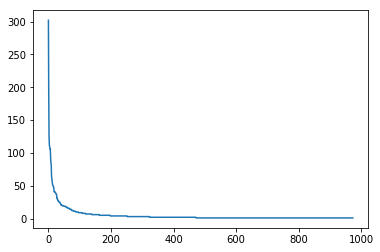

In [15]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

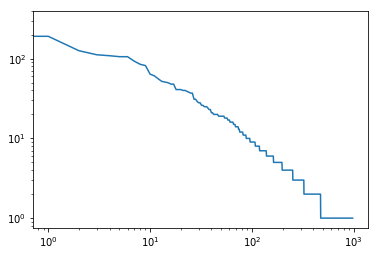

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.) 

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read in two weeks!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [17]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print(senateReleasesData['description'])

dict_keys(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'forks_count', 'mirror_url', 'archived', 'disabled', 'open_issues_count', 'lic

What we are interested in here is the `'contents_url'`

In [18]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [20]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'type': 'file',
 '_links': {'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
  'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https:/

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [21]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text. For analysis of its words, next we need to tokenize it, or split it into a sequence of tokens or word instances.

In [22]:
whTokens = word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 'Sen.',
 'Sheldon',
 'Whitehouse',
 'D']

Previous iterations of the course used `nltk`s tokenizer, but as we saw before, we used spaCy's model (https://spacy.io/api/tokenizer). We intend to avoid using NLTK when we can - for production level code, it is a lot faster and cleaner to use spaCy.

That being said, `nltk` does have some useful methods for quick analysis of small corpora. We will explore a few here, and encourage you to figure out for yourself which other ones might be useful.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [23]:
import nltk

In [41]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText) 
whitehouseIndex.print_concordance('Whitehouse')

Displaying 5 of 5 matches:
ld girl from Westerly Sen. Sheldon Whitehouse D R.I. on Tuesday April 10 2007 il
ral funding for stem cell research Whitehouse met Lila two weeks ago She was dia
 down over time Stem cell research Whitehouse explained could vastly improve the
s research might help or even cure Whitehouse said Whitehouse also praised the e
 help or even cure Whitehouse said Whitehouse also praised the efforts of Rhode 


*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

Or we can pick a word (or words) and find what words tend to occur around it.

In [42]:
whText.common_contexts(['stem'])

for_cell hope_cell time_cell own_cells joints_cell of_cell on_cells
the_cell embryonic_cells


We can also just count the number of times the word occurs.

In [46]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


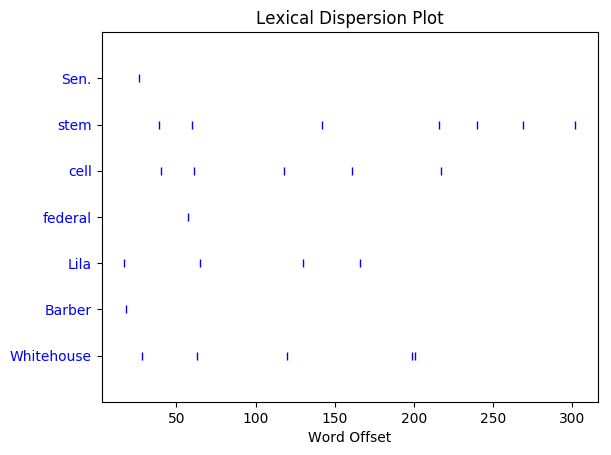

In [26]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [47]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

,name,text,path,html_url,download_url
0,10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,raw/Whitehouse/10Apr2007Whitehouse123.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
1,10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,raw/Whitehouse/10Apr2008Whitehouse2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
2,10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,raw/Whitehouse/10Apr2008Whitehouse3.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
3,10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,raw/Whitehouse/10Aug2007Whitehouse78.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
4,10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,raw/Whitehouse/10Jan2008Whitehouse35.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...


If you are having trouble downloading the data uncomment this next cell

In [48]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [49]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: word_tokenize(x))

Now lets see how long each of the press releases is:

In [50]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    350
1    311
2    497
3    189
4    236
5    334
6    241
7    469
8    443
9    425
Name: word_counts, dtype: int64

In [52]:
whReleases

,name,text,path,html_url,download_url,tokenized_text,word_counts
0,10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,raw/Whitehouse/10Apr2007Whitehouse123.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S, ...",350
1,10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,raw/Whitehouse/10Apr2008Whitehouse2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST,...",311
2,10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,raw/Whitehouse/10Apr2008Whitehouse3.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...",497
3,10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,raw/Whitehouse/10Aug2007Whitehouse78.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[R.I., SENATORS, PRAISE, SEN, DENIAL, OF, LNG,...",189
4,10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,raw/Whitehouse/10Jan2008Whitehouse35.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, COMMENTS, ON, ONE, YEAR, ANN...",236
5,10Mar2008Whitehouse8.txt,"SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...",raw/Whitehouse/10Mar2008Whitehouse8.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SENS, REED, WHITEHOUSE, WELCOME, RHODE, ISLAN...",334
6,10Sep2007Whitehouse72.txt,REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...,raw/Whitehouse/10Sep2007Whitehouse72.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[REP, WHITEHOUSE, ISSUES, STATEMENT, ON, GEN, ...",241
7,11Apr2007Whitehouse122.txt,SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...,raw/Whitehouse/11Apr2007Whitehouse122.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, URGES, BUSH, FOR, NEW, DIREC...",469
8,11Jan2007Whitehouse161.txt,"SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...",raw/Whitehouse/11Jan2007Whitehouse161.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SENS, REED, WHITEHOUSE, URGE, PORTUGAL, TO, R...",443
9,11Mar2008Whitehouse7.txt,WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...,raw/Whitehouse/11Mar2008Whitehouse7.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[WHITEHOUSE, UNVEILS, BUSH, DEBT, $, 7.7, TRIL...",425


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </span>

Notes: 

I am currently buiding a corpus that storing the description texts of each of the 10,000 artwork collections at the Art Institute of Chicago. The data is now being spiderred from the website of the museum. Since the website has a limitation against frequent requests, retrieving full data needs several days of distributed computing or multiprocessing with proxy IP address. Here I only use the data of the first 500 artwork listed on the website for this homework exercise. 

In [2]:
# Load the corpus
art_chicago_info_list = []
repo = '../museum'

for filename in os.listdir(repo): 
    if 'artwork_description' in filename and not filename.startswith('.'): 
        print(filename)
        art_chicago_info_list.append(pandas.read_csv(repo + '/' + filename, index_col=False))

art_chicago = pandas.concat(art_chicago_info_list)

0_artwork_description_150_250.csv
0_artwork_description_50_100.csv
0_artwork_description_300_400.csv
0_artwork_description_100_150.csv
0_artwork_description_400_500.csv
0_artwork_description_0_50.csv
0_artwork_description_250_300.csv


In [3]:
# Organize the records in the corpus by sorting on index
# index is the number of the artwork
art_chicago = art_chicago.sort_values(by=['index']).reset_index(drop=True)
art_chicago.head(10)

,artwork_title,description_text,index,url
0,"A Sunday on La Grande Jatte — 1884, 1884/86, G...","“Bedlam,” “scandal,” and “hilarity” were among...",0.0,https://www.artic.edu/artworks/27992/a-sunday-...
1,"Nighthawks, 1942, Edward Hopper",Edward Hopper said that Nighthawks was inspire...,1.0,https://www.artic.edu/artworks/111628/nighthawks
2,"American Gothic, 1930, Grant Wood",This familiar image was exhibited publicly for...,2.0,https://www.artic.edu/artworks/6565/american-g...
3,"The Bedroom, 1889, Vincent van Gogh",Vincent van Gogh so highly esteemed his bedroo...,3.0,https://www.artic.edu/artworks/28560/the-bedroom
4,"Nightlife, 1943, Archibald John Motley Jr.",Chicago painter Archibald Motley represented t...,4.0,https://www.artic.edu/artworks/117266/nightlife
5,"The Old Guitarist, late 1903–early 1904, Pablo...","Pablo Picasso produced The Old Guitarist, one ...",5.0,https://www.artic.edu/artworks/28067/the-old-g...
6,"Paris Street; Rainy Day, 1877, Gustave Cailleb...","This complex intersection, just minutes away f...",6.0,https://www.artic.edu/artworks/20684/paris-str...
7,Buddha Shakyamuni Seated in Meditation (Dhyana...,This meditating Buddha comes from the coastal ...,7.0,https://www.artic.edu/artworks/21023/buddha-sh...
8,"The Assumption of the Virgin, 1577–79, Domenic...",This painting was the central element of the a...,8.0,https://www.artic.edu/artworks/87479/the-assum...
9,Coronation Stone of Motecuhzoma II (Stone of t...,"This stone, commemorating the beginning of the...",10.0,https://www.artic.edu/artworks/75644/coronatio...


In [4]:
nlp = spacy.load("en")

In [5]:
# Define a function to tokenize the words
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [6]:
# Get the description texts in a array
art_chicago_words = art_chicago['description_text']

In [7]:
# Tokenize the words in all the descriptions and store in one list
art_chicago_words_list = []
for description in art_chicago_words: 
    art_chicago_words_list += word_tokenize(description)

In [8]:
# Preview the tokenized words
art_chicago_words_list[:10]

['Bedlam',
 'scandal',
 'and',
 'hilarity',
 'were',
 'among',
 'the',
 'epithets',
 'used',
 'to']

In [9]:
# Define a word counter
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [10]:
# Perform word counting on the museum corpus and return the word frequencies
word_count = wordCounter(art_chicago_words_list)
word_count.sort_values('count', ascending=False, inplace=True)
word_count[:100]

,word,count
6,the,6419
21,of,3938
2,and,2865
37,a,2149
32,in,2089
9,to,1448
17,’s,1005
228,his,945
45,as,767
59,with,733


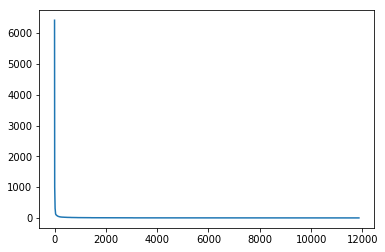

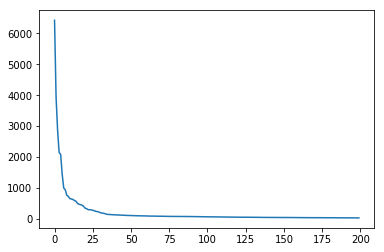

In [11]:
# Plot the word frequencies to see the Zipf's Law
fig = plt.figure()
plt.plot(range(len(word_count)), word_count['count'])
plt.show()

# The range of the x-axis is too wide to see any pattern. 
# Plot on another graph to see the reduction of frequency of the top 200 common-used words

# Plot the word frequencies again to see the Zipf's Law
plt.plot(range(len(word_count[:200])), word_count['count'][:200])
plt.show()

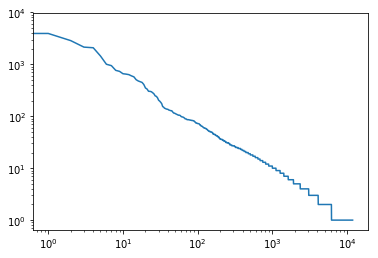

In [12]:
# Plot on with log axis
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(word_count)), word_count['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

The Zipf's Law is obvious in the museum language. 

In [13]:
# Use NLTK
import nltk

In [14]:
artText = nltk.Text(art_chicago_words_list)
artIndex = nltk.text.ConcordanceIndex(artText) 

In [15]:
artIndex.print_concordance('Chicago')

Displaying 25 of 25 matches:
 first time at the Art Institute of Chicago winning a three hundred dollar priz
d belonging to the Art Institute of Chicago painted a year later on the same sc
by the sharply receding perspective Chicago painter Archibald Motley represente
n Art New York the Art Institute of Chicago and the San Francisco Museum of Art
d smoking cannon In a letter to the Chicago lawyer Arthur Jerome Eddy who purch
n and lived most of his life in the Chicago area because of these ties he left 
ceived by Mrs. James Ward Thorne of Chicago and constructed between 1934 and 19
nse created in 1661 The metal frame Chicago Stock Exchange building was one of 
 young performers grew up The famed Chicago collector Mrs. Potter Palmer purcha
n addition to the Coonleys suburban Chicago estate which he had previously comp
ely self taught and as a teacher at Chicago ’s Institute of Design 1946–61 he c
male pedestrians lost in thought on Chicago ’s streets architectural facades hi
eanor and w

In [16]:
artIndex.print_concordance('London')

Displaying 14 of 14 matches:
int canvases for the ballroom of his London home In response Magritte conceived 
 that might allude to the bombing of London during World War II On the left a ne
ters indicate that he finished it in London the following year The completed ima
am the successful eighteenth century London architect whose precise and delicate
rst black man to play Othello on the London stage The Captive Slave highlights h
ited at the Royal Academy of Arts in London the accompanying catalogue included 
tist was working as a dresser at the London Coliseum One night after a productio
 a sheet draped bed in the artist ’s London studio With his head thrown back his
eft side now in the National Gallery London depicts the moment of Mary ’s own Im
tches that he often took back to his London studio to expand and then finish Of 
he Institute of Contemporary Arts in London This process purposefully blurred th
born painter John Smibert studied in London and Italy before settling in Boston 

In [17]:
artIndex.print_concordance('China')

Displaying 22 of 22 matches:
re ubiquitously displayed throughout China Warhol ’s looming portrait impresses
 refined sensibility of Song dynasty China ’s cultural elite members of the imp
 Jiangxi province which later became China ’s preeminent center for ceramic pro
 distinctive bronze vessels of early China represent important historical docum
overies of similar bronze vessels in China indicate that this cauldron was most
emes of the Xiao and Xiang Rivers in China each of which has its own poetic tit
handsome breeds that were brought to China from the empire ’s northwestern fron
d to Paris in 1948 He had studied at China ’s most progressive art academy trai
ormative stage in the development of China ’s renowned celadon glaze which beca
 monumental landscapes attributed to China ’s foremost painters of the tenth an
court ’s increasing fascinating with China As an allegory of good governance th
ded by French Jesuit missionaries in China between Louis XIV and Kangxi Due to 
into India 

In [18]:
artIndex.print_concordance('India')

Displaying 18 of 18 matches:
tal town of Nagapattinam in southern India which was as a result of settlers fr
ir becoming the seven holy rivers of India This classic bronze comes from the C
rom the Chola period in the south of India Icons such as this were carried in p
surance Buddhism which originated in India with the teachings of the Buddha Sak
mukha as well as Murugan in southern India where he is very popular This monume
ners in the Persian Gulf and Western India Later the Portuguese Omani and Briti
 Spanish influenced examples made in India Comparisons have also been made with
e rarely the subject of portraits in India In this monumental portrait therefor
siyar r. 1713–19 in various parts of India The painting has been dated to 1705/
 and the other tucked beneath her In India and Tibet she is often shown standin
ed flower bud Jade was imported into India from the Khotan region of China The 
of Brahman cattle originally bred in India Cows enjoy a respected status in Ind
dia Cows en

- "Chicago" appears frequently in the description of the artwork in the Art Institute of Chicago, many of which is used in the phrase "The Art Institute of Chicago". 

- But what is surprised is, "London" also appears very frequently. 
- Many artwork collections in the museum are related to Asia. 

In [19]:
artText.common_contexts(['art'])

the_institute century_the renaissance_which spanish_and french_in
major_museum american_in his_for japanese_cassatt an_movement ’s_in
american_new of_sky her_arranged of_interpreting him_paul
parisian_dealer his_beyond born_dealer an_gallery


In [20]:
artText.common_contexts(['China'])

throughout_warhol dynasty_’s became_’s early_represent in_indicate
in_each to_from at_’s of_’s to_’s with_as in_between of_the
transporting_’s 1736–95_’s supporting_’s in_self into_in asia_and


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


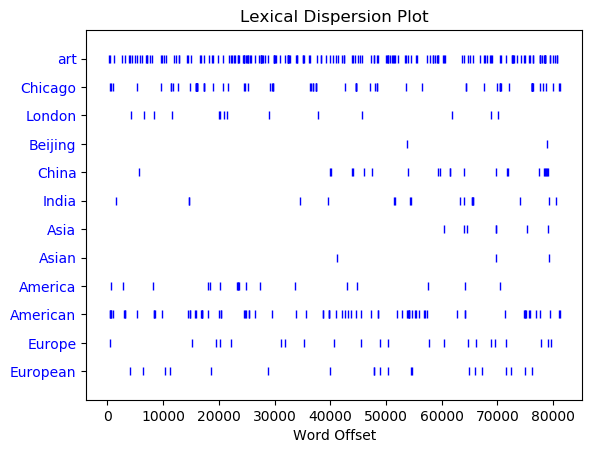

In [21]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
artText.dispersion_plot(['art','Chicago', 'London', 'Beijing', 'China', 'India', 'Asia', 'Asian', 'America', 'American', 'Europe', 'European'])
sns.set() #Re-enabling seaborn

Arts from different continents are related to each other. 

# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary). 

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word. 

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent then the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest. 

In [31]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('the', 179),
 ('of', 112),
 ('to', 112),
 ('and', 108),
 ('in', 64),
 ('a', 61),
 ("'s", 50),
 ('that', 41),
 ('our', 39),
 ('for', 35),
 ('on', 33),
 ('is', 33),
 ('Whitehouse', 31),
 ('Iraq', 28),
 ('Bush', 27),
 ('President', 25),
 ('troops', 21),
 ('American', 19),
 ('by', 19),
 ('Rhode', 18)]

We can look at this and pick the cutoff, often at the first noun. So we will cut all words before `'Whitehouse'`.

In [32]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the', 'of', 'to', 'and', 'in', 'a', "'s", 'that', 'our', 'for', 'on', 'is']

If we did have any extra words to add as stop words apart from those normally considered as stop words, we would add it to our stop words by passing it to the normalize tokens method. 

Now we can create our function to normalize the tokens

In [33]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [34]:
whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

,download_url,html_url,name,path,text,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Whitehouse123.txt,raw/Whitehouse/10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,"[SEN, WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S, ...",350,"[sen, whitehouse, share, westerly, girl, story...",224
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Whitehouse2.txt,raw/Whitehouse/10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,"[SEN, WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST,...",311,"[sen, whitehouse, say, president, bush, begin,...",159
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Whitehouse3.txt,raw/Whitehouse/10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,"[EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...",497,"[epa, review, legal, process, root, political,...",298
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2007Whitehouse78.txt,raw/Whitehouse/10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,"[R.I., SENATORS, PRAISE, SEN, DENIAL, OF, LNG,...",189,"[r.i, senator, praise, sen, denial, lng, facil...",116
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jan2008Whitehouse35.txt,raw/Whitehouse/10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,"[SEN, WHITEHOUSE, COMMENTS, ON, ONE, YEAR, ANN...",236,"[sen, whitehouse, comment, year, anniversary, ...",125
5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Mar2008Whitehouse8.txt,raw/Whitehouse/10Mar2008Whitehouse8.txt,"SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...","[SENS, REED, WHITEHOUSE, WELCOME, RHODE, ISLAN...",334,"[sens, reed, whitehouse, welcome, rhode, islan...",198
6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Sep2007Whitehouse72.txt,raw/Whitehouse/10Sep2007Whitehouse72.txt,REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...,"[REP, WHITEHOUSE, ISSUES, STATEMENT, ON, GEN, ...",241,"[rep, whitehouse, issue, statement, gen, petra...",118
7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Apr2007Whitehouse122.txt,raw/Whitehouse/11Apr2007Whitehouse122.txt,SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...,"[SEN, WHITEHOUSE, URGES, BUSH, FOR, NEW, DIREC...",469,"[sen, whitehouse, urge, bush, new, direction, ...",249
8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Jan2007Whitehouse161.txt,raw/Whitehouse/11Jan2007Whitehouse161.txt,"SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...","[SENS, REED, WHITEHOUSE, URGE, PORTUGAL, TO, R...",443,"[sens, reed, whitehouse, urge, portugal, recon...",237
9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Mar2008Whitehouse7.txt,raw/Whitehouse/11Mar2008Whitehouse7.txt,WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...,"[WHITEHOUSE, UNVEILS, BUSH, DEBT, $, 7.7, TRIL...",425,"[whitehouse, unveil, bush, debt, $, foregone, ...",242


You can see that in the final step of normalizing, we add the lemmatized form of the word. spaCy's built in lemmatizer does this (https://spacy.io/api/lemmatizer). Lemmatization can be thought of as finding the root or the base of the word after removing inflections and other variations of words. Another possible way of finding the roots of words is using NLTK's porting or stemming functionalities, but we will not be getting into them.

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [35]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

1966


From this we can lookup the distributions of different word lengths

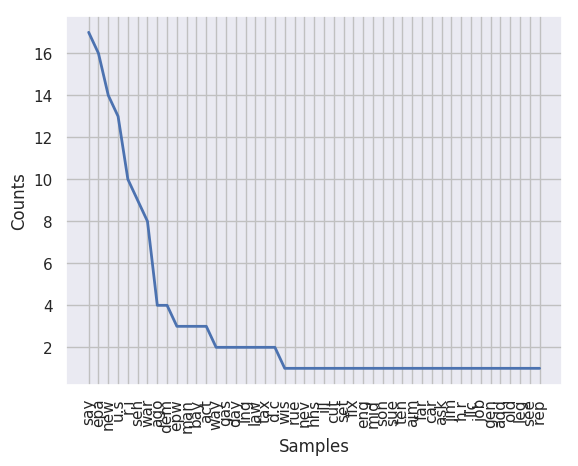

In [36]:
whcfdist[3].plot()

We can also create a Conditional Probability Distribution or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate for the probability distribution of the experiment used to generate the observed frequency distribution. 

In [37]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

ri
0.25


Length is one feature of a word, but there are many more important features we care about. Another critical feature is a word's role in the sentence, or its part of speech (POS). 

The method below works similarly to ```nltk.pos_text```, and can work with the conditional frequency distributions it provides.

In [38]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [39]:
whReleases['normalized_tokens_POS'] = [spacy_pos(t) for t in whReleases['text']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [40]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('academic', FreqDist({'JJ': 3, 'NNP': 1})),
 ('risks', FreqDist({'VBZ': 1, 'NNS': 1})),
 ('transplants', FreqDist({'NNS': 1})),
 ('class', FreqDist({'NN': 2})),
 ('research', FreqDist({'NN': 8, 'NNP': 1})),
 ('their', FreqDist({'PRP$': 15})),
 ('reid', FreqDist({'NNP': 1})),
 ('acknowledged', FreqDist({'VBD': 1})),
 ('urge', FreqDist({'VBP': 1})),
 ('august', FreqDist({'NNP': 1}))]

This gives the frequency of each word as each part of speech...which can be uninformative and boring. What we want is the converse; the frequency of each part of speech for each word.

In [41]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of the superlative adjectives

In [42]:
whcfdist_POStoWord['JJ']

FreqDist({'american': 17, 'new': 10, 'portuguese': 9, 'political': 8, 'federal': 6, 'clear': 5, 'fiscal': 5, 'potential': 5, 'last': 4, 'several': 4, ...})

Or look at the most common nouns

In [43]:
whcfdist_POStoWord['NN'].most_common(5)

[('today', 15),
 ('year', 12),
 ('administration', 11),
 ('consulate', 10),
 ('stem', 10)]

Or plot the base form verbs against their number of occurrences

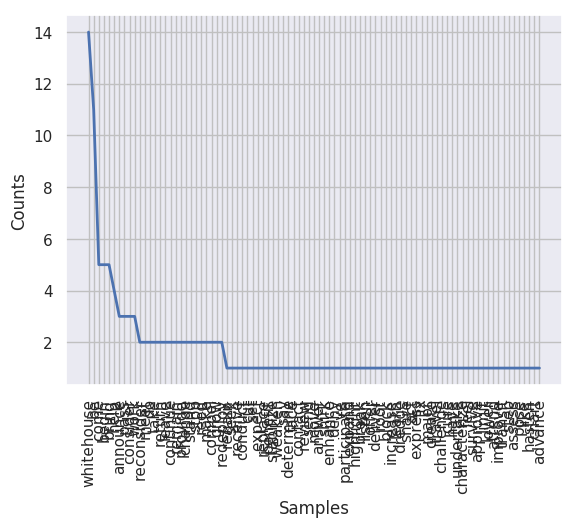

In [44]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [45]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

today
0.020195439739413682


We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

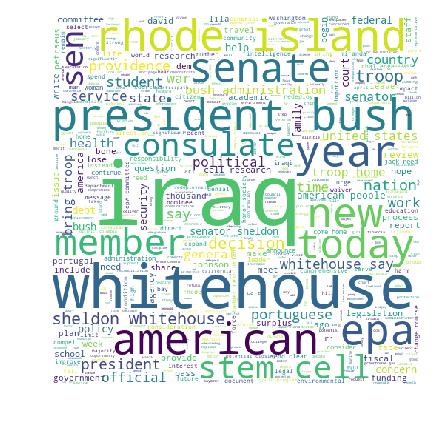

In [46]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</span>

In [42]:
# Tokenize the corpus and put it in the same dataframe

art_chicago['tokenized_text'] = art_chicago['description_text'].apply(lambda x: word_tokenize(x))
art_chicago['word_counts'] = art_chicago['tokenized_text'].apply(lambda x: len(x))
art_chicago.head(10)

,artwork_title,description_text,index,url,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS
0,"A Sunday on La Grande Jatte — 1884, 1884/86, G...","“Bedlam,” “scandal,” and “hilarity” were among...",0.0,https://www.artic.edu/artworks/27992/a-sunday-...,"[Bedlam, scandal, and, hilarity, were, among, ...",188,"[bedlam, scandal, hilarity, epithet, describe,...",98,"[(“, ``), (bedlam, NNP), (,, ,), (”, ''), (“, ..."
1,"Nighthawks, 1942, Edward Hopper",Edward Hopper said that Nighthawks was inspire...,1.0,https://www.artic.edu/artworks/111628/nighthawks,"[Edward, Hopper, said, that, Nighthawks, was, ...",215,"[edward, hopper, say, nighthawks, inspire, res...",110,"[(edward, NNP), (hopper, NNP), (said, VBD), (t..."
2,"American Gothic, 1930, Grant Wood",This familiar image was exhibited publicly for...,2.0,https://www.artic.edu/artworks/6565/american-g...,"[This, familiar, image, was, exhibited, public...",243,"[familiar, image, exhibit, publicly, time, art...",120,"[(this, DT), (familiar, JJ), (image, NN), (was..."
3,"The Bedroom, 1889, Vincent van Gogh",Vincent van Gogh so highly esteemed his bedroo...,3.0,https://www.artic.edu/artworks/28560/the-bedroom,"[Vincent, van, Gogh, so, highly, esteemed, his...",266,"[vincent, van, gogh, highly, esteem, bedroom, ...",134,"[(vincent, NNP), (van, NNP), (gogh, NNP), (so,..."
4,"Nightlife, 1943, Archibald John Motley Jr.",Chicago painter Archibald Motley represented t...,4.0,https://www.artic.edu/artworks/117266/nightlife,"[Chicago, painter, Archibald, Motley, represen...",212,"[chicago, painter, archibald, motley, represen...",119,"[(chicago, NNP), (painter, NNP), (archibald, N..."
5,"The Old Guitarist, late 1903–early 1904, Pablo...","Pablo Picasso produced The Old Guitarist, one ...",5.0,https://www.artic.edu/artworks/28067/the-old-g...,"[Pablo, Picasso, produced, The, Old, Guitarist...",190,"[pablo, picasso, produce, old, guitarist, haun...",99,"[(pablo, NNP), (picasso, NNP), (produced, VBD)..."
6,"Paris Street; Rainy Day, 1877, Gustave Cailleb...","This complex intersection, just minutes away f...",6.0,https://www.artic.edu/artworks/20684/paris-str...,"[This, complex, intersection, just, minutes, a...",198,"[complex, intersection, minute, away, saint, l...",122,"[(this, DT), (complex, JJ), (intersection, NN)..."
7,Buddha Shakyamuni Seated in Meditation (Dhyana...,This meditating Buddha comes from the coastal ...,7.0,https://www.artic.edu/artworks/21023/buddha-sh...,"[This, meditating, Buddha, comes, from, the, c...",135,"[meditate, buddha, come, coastal, town, nagapa...",69,"[(this, DT), (meditating, VBG), (buddha, NN), ..."
8,"The Assumption of the Virgin, 1577–79, Domenic...",This painting was the central element of the a...,8.0,https://www.artic.edu/artworks/87479/the-assum...,"[This, painting, was, the, central, element, o...",213,"[painting, central, element, altarpiece, el, g...",113,"[(this, DT), (painting, NN), (was, VBD), (the,..."
9,Coronation Stone of Motecuhzoma II (Stone of t...,"This stone, commemorating the beginning of the...",10.0,https://www.artic.edu/artworks/75644/coronatio...,"[This, stone, commemorating, the, beginning, o...",239,"[stone, commemorate, beginning, reign, emperor...",124,"[(this, DT), (stone, NN), (,, ,), (commemorati..."


In [43]:
# Find the most frequently-used words to decide what are stop words. 

countsDict = {}
for word in art_chicago['tokenized_text'].sum(): # Each piece of description are concantenated togather
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:50]

# Even though the first non-stop word is 'artist', 
# the words following 'artist' are still not relevant to our interests. 
# 'artist' can be very common in a art museum corpus. 
# We use the words before 'painted' 
# but mannually exclude 'artist', 'painting', 'work', 'art', 'century', 'life' as stop words. 

[('the', 5715),
 ('of', 3932),
 ('and', 2863),
 ('a', 2077),
 ('in', 1816),
 ('to', 1425),
 ('’s', 1005),
 ('his', 884),
 ('as', 724),
 ('The', 704),
 ('with', 680),
 ('is', 647),
 ('that', 628),
 ('was', 600),
 ('by', 547),
 ('an', 451),
 ('for', 445),
 ('this', 444),
 ('on', 427),
 ('he', 410),
 ('from', 399),
 ('artist', 330),
 ('at', 329),
 ('painting', 302),
 ('which', 301),
 ('work', 281),
 ('In', 273),
 ('her', 251),
 ('are', 226),
 ('This', 216),
 ('one', 208),
 ('it', 198),
 ('or', 196),
 ('its', 192),
 ('were', 186),
 ('art', 176),
 ('their', 160),
 ('most', 151),
 ('century', 136),
 ('into', 135),
 ('life', 134),
 ('be', 131),
 ('who', 130),
 ('two', 128),
 ('painted', 127),
 ('paintings', 122),
 ('Art', 121),
 ('made', 121),
 ('such', 115),
 ('also', 111)]

In [44]:
# The stop list is then all words that occur before the first verb
# We exclude some important words manually. 
stop_words_freq = set()
for word, count in word_counts:
    if word == 'painted':
        break
    else:
        stop_words_freq.add(word)
stop_words_freq = [i for i in (stop_words_freq - {'artist', 'painting', 'work', 'art', 'century', 'life'})]
stop_words_freq

['were',
 'their',
 'two',
 'who',
 'a',
 'which',
 'that',
 'and',
 'are',
 'as',
 'an',
 'to',
 'his',
 'or',
 'it',
 'its',
 'be',
 'In',
 'for',
 'he',
 'most',
 'her',
 'by',
 'with',
 'is',
 'this',
 'on',
 'This',
 '’s',
 'at',
 'of',
 'in',
 'The',
 'was',
 'the',
 'one',
 'from',
 'into']

In [45]:
# Define a function that normalizes tokens, which remove unrelevant words and lematize the words. 

def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [46]:
# Call the function and put the result into the dataframe. 
art_chicago['normalized_tokens'] = art_chicago['tokenized_text'].apply(lambda x: normalizeTokens(x))

art_chicago['normalized_tokens_count'] = art_chicago['normalized_tokens'].apply(lambda x: len(x))

art_chicago.head(15)

,artwork_title,description_text,index,url,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS
0,"A Sunday on La Grande Jatte — 1884, 1884/86, G...","“Bedlam,” “scandal,” and “hilarity” were among...",0.0,https://www.artic.edu/artworks/27992/a-sunday-...,"[Bedlam, scandal, and, hilarity, were, among, ...",188,"[bedlam, scandal, hilarity, epithet, describe,...",98,"[(“, ``), (bedlam, NNP), (,, ,), (”, ''), (“, ..."
1,"Nighthawks, 1942, Edward Hopper",Edward Hopper said that Nighthawks was inspire...,1.0,https://www.artic.edu/artworks/111628/nighthawks,"[Edward, Hopper, said, that, Nighthawks, was, ...",215,"[edward, hopper, say, nighthawks, inspire, res...",110,"[(edward, NNP), (hopper, NNP), (said, VBD), (t..."
2,"American Gothic, 1930, Grant Wood",This familiar image was exhibited publicly for...,2.0,https://www.artic.edu/artworks/6565/american-g...,"[This, familiar, image, was, exhibited, public...",243,"[familiar, image, exhibit, publicly, time, art...",120,"[(this, DT), (familiar, JJ), (image, NN), (was..."
3,"The Bedroom, 1889, Vincent van Gogh",Vincent van Gogh so highly esteemed his bedroo...,3.0,https://www.artic.edu/artworks/28560/the-bedroom,"[Vincent, van, Gogh, so, highly, esteemed, his...",266,"[vincent, van, gogh, highly, esteem, bedroom, ...",134,"[(vincent, NNP), (van, NNP), (gogh, NNP), (so,..."
4,"Nightlife, 1943, Archibald John Motley Jr.",Chicago painter Archibald Motley represented t...,4.0,https://www.artic.edu/artworks/117266/nightlife,"[Chicago, painter, Archibald, Motley, represen...",212,"[chicago, painter, archibald, motley, represen...",119,"[(chicago, NNP), (painter, NNP), (archibald, N..."
5,"The Old Guitarist, late 1903–early 1904, Pablo...","Pablo Picasso produced The Old Guitarist, one ...",5.0,https://www.artic.edu/artworks/28067/the-old-g...,"[Pablo, Picasso, produced, The, Old, Guitarist...",190,"[pablo, picasso, produce, old, guitarist, haun...",99,"[(pablo, NNP), (picasso, NNP), (produced, VBD)..."
6,"Paris Street; Rainy Day, 1877, Gustave Cailleb...","This complex intersection, just minutes away f...",6.0,https://www.artic.edu/artworks/20684/paris-str...,"[This, complex, intersection, just, minutes, a...",198,"[complex, intersection, minute, away, saint, l...",122,"[(this, DT), (complex, JJ), (intersection, NN)..."
7,Buddha Shakyamuni Seated in Meditation (Dhyana...,This meditating Buddha comes from the coastal ...,7.0,https://www.artic.edu/artworks/21023/buddha-sh...,"[This, meditating, Buddha, comes, from, the, c...",135,"[meditate, buddha, come, coastal, town, nagapa...",69,"[(this, DT), (meditating, VBG), (buddha, NN), ..."
8,"The Assumption of the Virgin, 1577–79, Domenic...",This painting was the central element of the a...,8.0,https://www.artic.edu/artworks/87479/the-assum...,"[This, painting, was, the, central, element, o...",213,"[painting, central, element, altarpiece, el, g...",113,"[(this, DT), (painting, NN), (was, VBD), (the,..."
9,Coronation Stone of Motecuhzoma II (Stone of t...,"This stone, commemorating the beginning of the...",10.0,https://www.artic.edu/artworks/75644/coronatio...,"[This, stone, commemorating, the, beginning, o...",239,"[stone, commemorate, beginning, reign, emperor...",124,"[(this, DT), (stone, NN), (,, ,), (commemorati..."


In [47]:
# Calculate the conditional frequencies. 
# E.g. Here we calculate the frequencies conditional on word length. 

#.sum() adds together the lists from each row into a single list
art_chicago_cfdist = nltk.ConditionalFreqDist(((len(w), w) for w in art_chicago['normalized_tokens'].sum()))

#print the number of words
print(art_chicago_cfdist.N())

44396


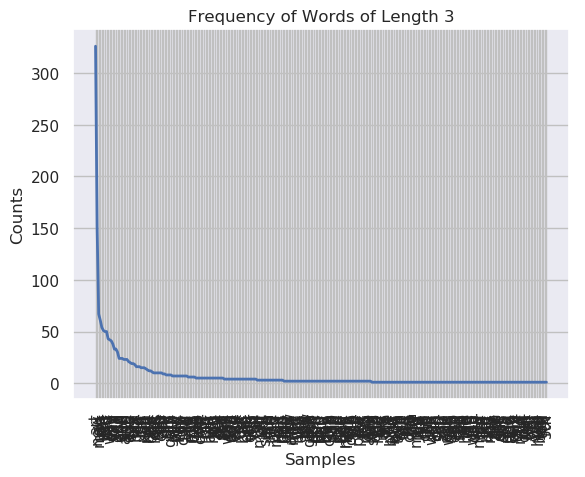

In [48]:
# Plot the frequency of words of length 3. 
art_chicago_cfdist[3].plot(title='Frequency of Words of Length 3')

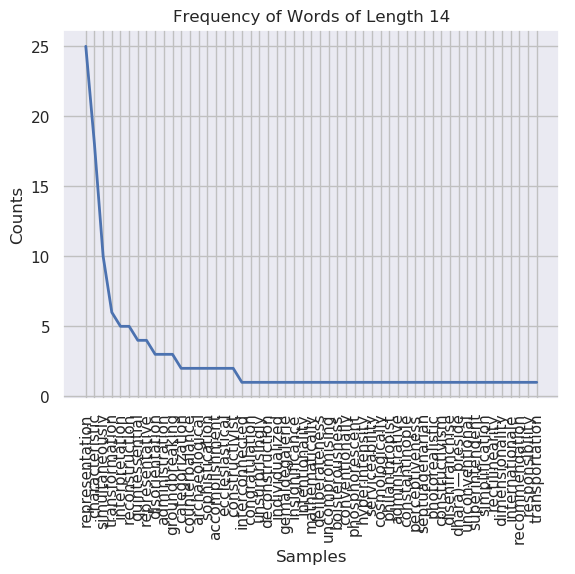

In [49]:
# The axis is messy. We want to see the usage of some long words in museum language. 
art_chicago_cfdist[14].plot(title='Frequency of Words of Length 14')

In [50]:
# Calculate conditional probability distribution based on frequncy 

art_chicago_cpdist = nltk.ConditionalProbDist(art_chicago_cfdist, nltk.ELEProbDist)

# print the most common 2 letter word
for length in range(2, 15):
    print(f'The most common {length} letter word    {art_chicago_cpdist[length].max()}   , which density is {art_chicago_cpdist[length].prob(art_chicago_cpdist[length].max())}')


The most common 2 letter word    de   , which density is 0.23782771535580524
The most common 3 letter word    art   , which density is 0.1440864960282436
The most common 4 letter word    work   , which density is 0.06116438356164384
The most common 5 letter word    paint   , which density is 0.02961316674675637
The most common 6 letter word    artist   , which density is 0.0496313925814129
The most common 7 letter word    century   , which density is 0.02084899856449518
The most common 8 letter word    painting   , which density is 0.07332189168573608
The most common 9 letter word    sculpture   , which density is 0.023089679806097718
The most common 10 letter word    photograph   , which density is 0.01973812780926324
The most common 11 letter word    composition   , which density is 0.07162965279949952
The most common 12 letter word    architecture   , which density is 0.04398826979472141
The most common 13 letter word    architectural   , which density is 0.05580865603644647
The mos

In [51]:
# Define a function that return a list of the part of speech (POS) of each word in a list
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [52]:
# Identify the POS of the words in each description
art_chicago['normalized_tokens_POS'] = [spacy_pos(t) for t in art_chicago['description_text']]
# this gives a new column with the part of speech as a short initialism and the word in a tuple

In [53]:
# Construct the conditional frequency distribution conditional on POS
art_chicago_cfdist_WordtoPOS = nltk.ConditionalFreqDist(art_chicago['normalized_tokens_POS'].sum())
list(art_chicago_cfdist_WordtoPOS.items())[10:20]

[('epithets', FreqDist({'NNS': 1})),
 ('used', FreqDist({'VBN': 39, 'VBD': 36, 'JJ': 1})),
 ('to', FreqDist({'IN': 748, 'TO': 700})),
 ('describe', FreqDist({'VB': 8, 'VBP': 1})),
 ('what', FreqDist({'WP': 44, 'WDT': 1})),
 ('is', FreqDist({'VBZ': 649})),
 ('now', FreqDist({'RB': 27})),
 ('considered', FreqDist({'VBN': 19, 'VBD': 8})),
 ('georges', FreqDist({'NNP': 7, 'NNS': 5})),
 ('seurat', FreqDist({'NNP': 6}))]

In [54]:
# This gives the frequency of each word as each part of speech...which can be uninformative and boring. 
# What we want is the converse; the frequency of each part of speech for each word.
art_chicago_cfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in art_chicago['normalized_tokens_POS'].sum())
list(art_chicago_cfdist_POStoWord.items())[10:15]

[('VBN',
  FreqDist({'made': 84, 'painted': 78, 'been': 74, 'known': 64, 'inspired': 47, 'used': 39, 'seen': 35, 'born': 34, 'based': 33, 'produced': 28, ...})),
 ('TO', FreqDist({'to': 700})),
 ('VB',
  FreqDist({'be': 131, 'have': 63, 'create': 36, 'represent': 22, 'make': 19, 'paint': 18, 'produce': 15, 'depict': 13, 'become': 12, 'suggest': 12, ...})),
 ('WP', FreqDist({'who': 132, 'what': 44, 'whom': 11, 'whoever': 1})),
 ('VBZ',
  FreqDist({'is': 649, 'has': 84, 'depicts': 43, 'seems': 41, '’s': 27, 'appears': 27, 'represents': 26, 'refers': 17, 'suggests': 17, 'shows': 16, ...}))]

In [55]:
# Identify and collect all of the superlative adjectives
art_chicago_cfdist_POStoWord['JJ']

FreqDist({'such': 114, 'early': 96, 'other': 92, 'many': 87, 'first': 82, 'new': 81, 'white': 73, 'large': 73, 'black': 61, 'american': 57, ...})

In [56]:
# The most common nouns
art_chicago_cfdist_POStoWord['NN'].most_common(10)
# This is pretty much consistent to what a museum language corpus should look like

[('artist', 328),
 ('painting', 279),
 ('work', 273),
 ('art', 211),
 ('century', 136),
 ('life', 135),
 ('color', 98),
 ('style', 97),
 ('figure', 97),
 ('form', 89)]

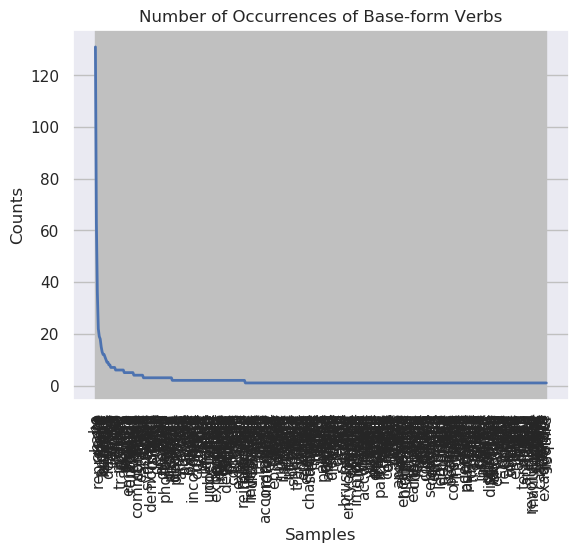

In [57]:
# plot the base form verbs against their number of occurrences
art_chicago_cfdist_POStoWord['VB'].plot(title='Number of Occurrences of Base-form Verbs')

In [58]:
# Perform a similar analysis of the word probabilities conditioanl on POC
art_chicago_cfdist_POStoWord = nltk.ConditionalProbDist(art_chicago_cfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print('the most common nouns and its probability: ')
print(art_chicago_cfdist_POStoWord['NN'].max())

#And its probability
print(art_chicago_cfdist_POStoWord['NN'].prob(art_chicago_cfdist_POStoWord['NN'].max()))

the most common nouns and its probability: 
artist
0.018893426122965434


In [75]:
#print the most common adjective
print('the most common nouns and its probability: ')
print(art_chicago_cfdist_POStoWord['JJ'].max())

#And its probability
print(art_chicago_cfdist_POStoWord['JJ'].prob(art_chicago_cfdist_POStoWord['JJ'].max()))

the most common nouns and its probability: 
such
0.012017212426532326


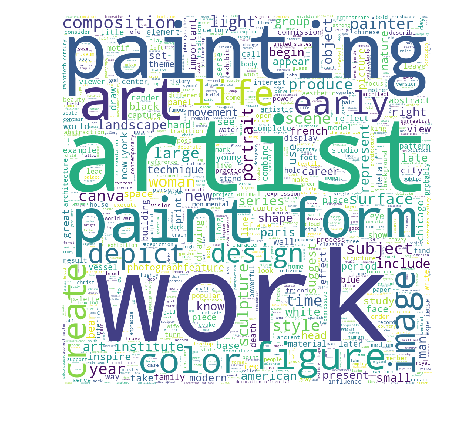

In [59]:
# Draw a word cloud
wc = wordcloud.WordCloud(background_color="white", max_words=1000, width= 2000, height = 2000, mode ='RGBA', scale=.5).generate(' '.join(art_chicago['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("art_institute_of_chicago_word_cloud.pdf", format = 'pdf')

The most frequent words are those that are usually used for describing an artwork or commenting on an artist's career. The most frequently used words are mostly nouns and verbs, and most words are neutral. This suggests the Art Institute of Chicago tend to document the collections unbiasedly. 

## Davies Corpora

Now that we have our basic cleaning down, we can arrange our Davies Corpora. Let us try this with the movies corpora we have already loaded.

We'll use a smaller corpus of a 1000 movies for this demonstration.

In [47]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [48]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [49]:
source[0:20]

[b'textID\tfileID\t#words\tgenre\tyear\tlanguage(s)\tcountry\timdb\ttitle\r\n',
 b'-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\r\n',
 b'\r\n',
 b'290635\t3547424\t4722\tShort, Musical\t1930\tUK\tEnglish\t0290635\tGoodbye to All That\r\n',
 b'21165\t6332374\t10220\tCrime, Mystery, Thriller\t1930\tUK\tEnglish\t0021165\tMurder!\r\n',
 b'21191\t6013789\t5281\tDrama, Romance\t1930\tUSA\tEnglish\t0021191\tA Notorious Affair\r\n',
 b'20620\t3660608\t6724\tBiography, Drama, History\t1930\tUSA\tEnglish\t0020620\tAbraham Lincoln\r\n',
 b'20629\t60053\t9552\tDrama, War\t1930\tUSA\tEnglish, French, German, Latin\t0020629\tAll Quiet on the Western Front\r\n',
 b'20640\t6850720\t13862\tComedy, Musical\t1930\tUSA\tEnglish\t0020640\tAnimal Crackers\r\n',
 b'20641\t176501\t11140\tDrama, Romance\t1930\tUSA\tEnglish\t0020641\tAnna Christie\r\n',
 b'20643\t3603861\t1748\tComedy, Short\t1930\tUSA\tEnglish\t0020643\tAnother Fine Mess\r\n',
 b'20670\t4159455\t6966\tComedy, Musical\t1930\tUS

It looks dirty because the file is encoded as bytes, but we can certainly see the information there. The file id is also present in the original raw text data: as the first "word". Look back at the normalized/tokenized words to confirm that. We're going to use this to create a dataframe with: Fileid, movie name, genre, year, and country.

It is advised that you run a similar check of the source file before you do other extraction.

First, let us create a dictionary mapping file-id to all the text. Each movie will be mapped to a list of the tokenized words.

In this example, I only use it to load 100 movies. You can comment this out or increase/decrease the number as you see fit.

In [50]:
movie_texts = {}

In [51]:
for files in movie_raw:
    if len(movie_texts) > 100:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        txts = lucem_illud_2020.word_tokenize(movie)
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [52]:
import pandas as pd

In [53]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Tokenized Texts"])

In [54]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [55]:
movie_df.head()

,Movie Name,Genre,Year,Country,Tokenized Texts
3147360,The Devil's Parade,Short,1930,English,"[Good, luck, Hi, Uh, I, have, an, appointment,..."
3276830,Smart Money,"Crime, Drama",1931,English,"[Aces, Fine, Come, on, ace, Ah, Thank, goodnes..."
6750675,The Mad Genius,"Drama, Horror, Romance",1931,English,"[Not, so, high, on, your, left, string, Faster..."
6837507,"Hey, Pop!","Short, Comedy",1932,English,"[One, glass, of, milk, One, pork, sandwich, to..."
4194247,One Hour with You,"Comedy, Musical, Romance",1932,"English, French","[Now, listen, men, Spring, is, here, and, spri..."


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [56]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")


In [57]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA PROPN NNP
to PART TO
get AUX VB
some DET DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [58]:
redditDF = pandas.read_csv('../data/reddit.csv')

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word). Here, we will use sentences tokenized by spaCy. Like before, these methods can also be found in lucem_illud.



In [59]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [60]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

,Unnamed: 0,author,over_18,score,subreddit,text,title,url,sentences
9,8,brenkelieshere,False,9448,Tales From Tech Support,"Last year, Help Desk got a call from a user co...",How to fix a laptop that won't boot in under a...,https://www.reddit.com/r/talesfromtechsupport/...,"[[Last, year, Help, Desk, got, a, call, from, ..."
8,7,Bombadils,False,10528,Tales From Tech Support,First post in quite some time! I work at a loc...,"OK, now the password is 'D35p41r'",https://www.reddit.com/r/talesfromtechsupport/...,"[[First, post, in, quite, some, time], [I, wor..."
7,1200,whenlifegivesyoushit,False,11003,Relationships,[Original Post](https://www.reddit.com/r/relat...,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,https://www.reddit.com/r/relationships/comment...,"[[Original, Post](https://www.reddit.com, r, r..."
6,6,sfsdfd,False,11295,Tales From Tech Support,I witnessed this astounding IT meltdown around...,"Company-wide email + 30,000 employees + auto-r...",https://www.reddit.com/r/talesfromtechsupport/...,"[[I, witnessed, this, astounding, IT, meltdown..."
5,5,Raitaro,False,12372,Tales From Tech Support,I work Helpdesk for a retail store chain in th...,I'm pretty sure I knocked a user out from near...,https://www.reddit.com/r/talesfromtechsupport/...,"[[I, work, Helpdesk, for, a, retail, store, ch..."
4,4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened], [So, I, had, a, lapto..."
3,3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours], [..."
2,2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[Part, 1](http://www.reddit.com, r, talesfrom..."
1,1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>], [$, Me], [Hello, IT], [>, $], [Usr, Hi, ..."
0,0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [61]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [62]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_pos(x))

In [63]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (Help, NNP), (Desk, ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, P...
7    [[(Original, NNP), (Post](https://www.reddit.c...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBD)], [(...
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[(Part, NN), (1](http://www.reddit.com, CD), ...
1    [[(>, XX)], [($, $)], [(Me, PRP)], [(Hello, UH...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [64]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 21),
 ('m', 21),
 ('time', 14),
 ('computer', 13),
 ('lot', 12),
 ('email', 11),
 ('life', 11),
 ('system', 10),
 ('Genius', 9),
 ('message', 9),
 ('day', 9),
 ('laptop', 9),
 ('auto', 9),
 ('today', 8),
 ('part', 8),
 ('story', 8),
 ('call', 8),
 ('office', 8),
 ('user', 7),
 ('something', 7)]

What about the adjectives that modify the word, "computer"?

In [65]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'unrestricted', 'own'}


## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [76]:
art_chicago.head(10)

,artwork_title,description_text,index,url,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS
0,"A Sunday on La Grande Jatte — 1884, 1884/86, G...","“Bedlam,” “scandal,” and “hilarity” were among...",0.0,https://www.artic.edu/artworks/27992/a-sunday-...,"[Bedlam, scandal, and, hilarity, were, among, ...",188,"[bedlam, scandal, hilarity, epithet, describe,...",98,"[(“, ``), (bedlam, NNP), (,, ,), (”, ''), (“, ..."
1,"Nighthawks, 1942, Edward Hopper",Edward Hopper said that Nighthawks was inspire...,1.0,https://www.artic.edu/artworks/111628/nighthawks,"[Edward, Hopper, said, that, Nighthawks, was, ...",215,"[edward, hopper, say, nighthawks, inspire, res...",110,"[(edward, NNP), (hopper, NNP), (said, VBD), (t..."
2,"American Gothic, 1930, Grant Wood",This familiar image was exhibited publicly for...,2.0,https://www.artic.edu/artworks/6565/american-g...,"[This, familiar, image, was, exhibited, public...",243,"[familiar, image, exhibit, publicly, time, art...",120,"[(this, DT), (familiar, JJ), (image, NN), (was..."
3,"The Bedroom, 1889, Vincent van Gogh",Vincent van Gogh so highly esteemed his bedroo...,3.0,https://www.artic.edu/artworks/28560/the-bedroom,"[Vincent, van, Gogh, so, highly, esteemed, his...",266,"[vincent, van, gogh, highly, esteem, bedroom, ...",134,"[(vincent, NNP), (van, NNP), (gogh, NNP), (so,..."
4,"Nightlife, 1943, Archibald John Motley Jr.",Chicago painter Archibald Motley represented t...,4.0,https://www.artic.edu/artworks/117266/nightlife,"[Chicago, painter, Archibald, Motley, represen...",212,"[chicago, painter, archibald, motley, represen...",119,"[(chicago, NNP), (painter, NNP), (archibald, N..."
5,"The Old Guitarist, late 1903–early 1904, Pablo...","Pablo Picasso produced The Old Guitarist, one ...",5.0,https://www.artic.edu/artworks/28067/the-old-g...,"[Pablo, Picasso, produced, The, Old, Guitarist...",190,"[pablo, picasso, produce, old, guitarist, haun...",99,"[(pablo, NNP), (picasso, NNP), (produced, VBD)..."
6,"Paris Street; Rainy Day, 1877, Gustave Cailleb...","This complex intersection, just minutes away f...",6.0,https://www.artic.edu/artworks/20684/paris-str...,"[This, complex, intersection, just, minutes, a...",198,"[complex, intersection, minute, away, saint, l...",122,"[(this, DT), (complex, JJ), (intersection, NN)..."
7,Buddha Shakyamuni Seated in Meditation (Dhyana...,This meditating Buddha comes from the coastal ...,7.0,https://www.artic.edu/artworks/21023/buddha-sh...,"[This, meditating, Buddha, comes, from, the, c...",135,"[meditate, buddha, come, coastal, town, nagapa...",69,"[(this, DT), (meditating, VBG), (buddha, NN), ..."
8,"The Assumption of the Virgin, 1577–79, Domenic...",This painting was the central element of the a...,8.0,https://www.artic.edu/artworks/87479/the-assum...,"[This, painting, was, the, central, element, o...",213,"[painting, central, element, altarpiece, el, g...",113,"[(this, DT), (painting, NN), (was, VBD), (the,..."
9,Coronation Stone of Motecuhzoma II (Stone of t...,"This stone, commemorating the beginning of the...",10.0,https://www.artic.edu/artworks/75644/coronatio...,"[This, stone, commemorating, the, beginning, o...",239,"[stone, commemorate, beginning, reign, emperor...",124,"[(this, DT), (stone, NN), (,, ,), (commemorati..."


In [77]:
# Define a function that tokenize sentences
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [78]:
# Tokenize sentences in the museum corpus
art_chicago['sentences'] = art_chicago['description_text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
art_chicago.head(10)

,artwork_title,description_text,index,url,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,sentences
0,"A Sunday on La Grande Jatte — 1884, 1884/86, G...","“Bedlam,” “scandal,” and “hilarity” were among...",0.0,https://www.artic.edu/artworks/27992/a-sunday-...,"[Bedlam, scandal, and, hilarity, were, among, ...",188,"[bedlam, scandal, hilarity, epithet, describe,...",98,"[(“, ``), (bedlam, NNP), (,, ,), (”, ''), (“, ...","[[Bedlam, scandal, and, hilarity, were, among,..."
1,"Nighthawks, 1942, Edward Hopper",Edward Hopper said that Nighthawks was inspire...,1.0,https://www.artic.edu/artworks/111628/nighthawks,"[Edward, Hopper, said, that, Nighthawks, was, ...",215,"[edward, hopper, say, nighthawks, inspire, res...",110,"[(edward, NNP), (hopper, NNP), (said, VBD), (t...","[[Edward, Hopper, said, that, Nighthawks, was,..."
2,"American Gothic, 1930, Grant Wood",This familiar image was exhibited publicly for...,2.0,https://www.artic.edu/artworks/6565/american-g...,"[This, familiar, image, was, exhibited, public...",243,"[familiar, image, exhibit, publicly, time, art...",120,"[(this, DT), (familiar, JJ), (image, NN), (was...","[[This, familiar, image, was, exhibited, publi..."
3,"The Bedroom, 1889, Vincent van Gogh",Vincent van Gogh so highly esteemed his bedroo...,3.0,https://www.artic.edu/artworks/28560/the-bedroom,"[Vincent, van, Gogh, so, highly, esteemed, his...",266,"[vincent, van, gogh, highly, esteem, bedroom, ...",134,"[(vincent, NNP), (van, NNP), (gogh, NNP), (so,...","[[Vincent, van, Gogh, so, highly, esteemed, hi..."
4,"Nightlife, 1943, Archibald John Motley Jr.",Chicago painter Archibald Motley represented t...,4.0,https://www.artic.edu/artworks/117266/nightlife,"[Chicago, painter, Archibald, Motley, represen...",212,"[chicago, painter, archibald, motley, represen...",119,"[(chicago, NNP), (painter, NNP), (archibald, N...","[[Chicago, painter, Archibald, Motley, represe..."
5,"The Old Guitarist, late 1903–early 1904, Pablo...","Pablo Picasso produced The Old Guitarist, one ...",5.0,https://www.artic.edu/artworks/28067/the-old-g...,"[Pablo, Picasso, produced, The, Old, Guitarist...",190,"[pablo, picasso, produce, old, guitarist, haun...",99,"[(pablo, NNP), (picasso, NNP), (produced, VBD)...","[[Pablo, Picasso, produced, The, Old, Guitaris..."
6,"Paris Street; Rainy Day, 1877, Gustave Cailleb...","This complex intersection, just minutes away f...",6.0,https://www.artic.edu/artworks/20684/paris-str...,"[This, complex, intersection, just, minutes, a...",198,"[complex, intersection, minute, away, saint, l...",122,"[(this, DT), (complex, JJ), (intersection, NN)...","[[This, complex, intersection, just, minutes, ..."
7,Buddha Shakyamuni Seated in Meditation (Dhyana...,This meditating Buddha comes from the coastal ...,7.0,https://www.artic.edu/artworks/21023/buddha-sh...,"[This, meditating, Buddha, comes, from, the, c...",135,"[meditate, buddha, come, coastal, town, nagapa...",69,"[(this, DT), (meditating, VBG), (buddha, NN), ...","[[This, meditating, Buddha, comes, from, the, ..."
8,"The Assumption of the Virgin, 1577–79, Domenic...",This painting was the central element of the a...,8.0,https://www.artic.edu/artworks/87479/the-assum...,"[This, painting, was, the, central, element, o...",213,"[painting, central, element, altarpiece, el, g...",113,"[(this, DT), (painting, NN), (was, VBD), (the,...","[[This, painting, was, the, central, element, ..."
9,Coronation Stone of Motecuhzoma II (Stone of t...,"This stone, commemorating the beginning of the...",10.0,https://www.artic.edu/artworks/75644/coronatio...,"[This, stone, commemorating, the, beginning, o...",239,"[stone, commemorate, beginning, reign, emperor...",124,"[(this, DT), (stone, NN), (,, ,), (commemorati...","[[This, stone, commemorating, the, beginning, ..."


In [79]:
# Define a function that tags POS of each sentence
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [80]:
# Tags POS of each sentence
art_chicago['POS_sents'] = art_chicago['sentences'].apply(lambda x: tag_sents_pos(x))

In [81]:
art_chicago['POS_sents'].head(10)

0    [[(Bedlam, NNP), (scandal, NN), (and, CC), (hi...
1    [[(Edward, NNP), (Hopper, NNP), (said, VBD), (...
2    [[(This, DT), (familiar, JJ), (image, NN), (wa...
3    [[(Vincent, NNP), (van, NNP), (Gogh, NNP), (so...
4    [[(Chicago, NNP), (painter, NN), (Archibald, N...
5    [[(Pablo, NNP), (Picasso, NNP), (produced, VBD...
6    [[(This, DT), (complex, JJ), (intersection, NN...
7    [[(This, DT), (meditating, VBG), (Buddha, NNP)...
8    [[(This, DT), (painting, NN), (was, VBD), (the...
9    [[(This, DT), (stone, NN), (commemorating, VBG...
Name: POS_sents, dtype: object

In [82]:
# Count the frequncies of NN words

countTarget = 'NN'
targetCounts = {}
for entry in art_chicago['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

# Most of the common nouns refer to objects related to ART. 

[('artist', 329),
 ('work', 270),
 ('painting', 258),
 ('art', 175),
 ('life', 134),
 ('century', 131),
 ('style', 95),
 ('figure', 95),
 ('color', 94),
 ('form', 89),
 ('composition', 85),
 ('image', 81),
 ('time', 81),
 ('sculpture', 81),
 ('series', 81),
 ('painter', 72),
 ('canvas', 68),
 ('subject', 65),
 ('surface', 64),
 ('career', 60)]

In [83]:
# Count the frequncies of VB or VBG words

countTarget = 'VB' or 'VBG'
targetCounts = {}
for entry in art_chicago['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

# Many verbs are commmon verbs that are usually used for describing the motion of an artist, 
# E.g. create, paint, make, produce, suggest, achieve, etc. 
# Others are common verbs that are usually used for describing the meaning of an artwork, 
# E.g. depict, reflect, convey, etc. 

[('be', 131),
 ('have', 62),
 ('create', 36),
 ('represent', 20),
 ('paint', 18),
 ('make', 17),
 ('produce', 15),
 ('depict', 13),
 ('become', 12),
 ('suggest', 12),
 ('achieve', 11),
 ('work', 10),
 ('reflect', 9),
 ('record', 9),
 ('describe', 8),
 ('convey', 7),
 ('focus', 7),
 ('render', 7),
 ('go', 6),
 ('do', 6)]

In [84]:
# Count the frequncies of VBD words

countTarget = 'VBD'
targetCounts = {}
for entry in art_chicago['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

# The usage of past-tense verbs are similar to that of base-form verbs. 

[('was', 600),
 ('were', 186),
 ('had', 103),
 ('began', 61),
 ('made', 55),
 ('painted', 55),
 ('became', 50),
 ('used', 36),
 ('created', 34),
 ('produced', 33),
 ('worked', 28),
 ('called', 26),
 ('took', 26),
 ('did', 24),
 ('wrote', 23),
 ('depicted', 23),
 ('included', 22),
 ('left', 20),
 ('moved', 16),
 ('traveled', 16)]

In [85]:
# Count the frequncies of JJ words

countTarget = 'JJ'
targetCounts = {}
for entry in art_chicago['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

# adjectives are those that can be used for describing an artwork or an artist. 

[('such', 108),
 ('early', 95),
 ('other', 89),
 ('many', 81),
 ('first', 79),
 ('new', 76),
 ('large', 71),
 ('white', 59),
 ('American', 59),
 ('black', 55),
 ('own', 51),
 ('important', 50),
 ('modern', 50),
 ('late', 48),
 ('young', 45),
 ('small', 44),
 ('French', 42),
 ('artistic', 41),
 ('popular', 40),
 ('great', 36)]

In [86]:
# Count the frequncies of JJR words

countTarget = 'JJR'
targetCounts = {}
for entry in art_chicago['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

# comparative adjectives are those that can be used for describing an artwork or an artist. 

[('more', 34),
 ('earlier', 24),
 ('smaller', 15),
 ('lower', 15),
 ('larger', 10),
 ('less', 6),
 ('older', 6),
 ('greater', 4),
 ('younger', 3),
 ('darker', 3),
 ('taller', 2),
 ('More', 2),
 ('higher', 2),
 ('simpler', 2),
 ('trickster', 1),
 ('shorter', 1),
 ('closer', 1),
 ('courtier', 1),
 ('slender', 1),
 ('brighter', 1)]

In [87]:
# Count the frequncies of JJS words

countTarget = 'JJS'
targetCounts = {}
for entry in art_chicago['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

# superlative adjectives are those that can be used for describing an artwork or an artist. 

[('most', 26),
 ('finest', 14),
 ('largest', 12),
 ('earliest', 12),
 ('greatest', 7),
 ('least', 5),
 ('latest', 4),
 ('best', 4),
 ('highest', 3),
 ('closest', 2),
 ('strongest', 2),
 ('richest', 1),
 ('minutest', 1),
 ('tiniest', 1),
 ('widest', 1),
 ('simplest', 1),
 ('grandest', 1),
 ('farthest', 1),
 ('eldest', 1),
 ('smallest', 1)]

In [88]:
# Let's see what the superlative adjectives are used for what nouns: 
NTarget1 = 'JJ'
NTarget2 = 'NN'
NResults = set()
for entry in art_chicago['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1, kind2)==(NTarget1, NTarget2):
                NResults.add((ent1, ent2))
            else:
                continue

for record in list(NResults)[:20]: 
    print(record)
    
    
# Adjectives are more likely to be used for describing some features of an artwork. 

('great', 'fascination')
('classical', 'simplicity')
('Surrealist', 'leader')
('upper', 'portion')
('dramatic', 'fervor')
('double', 'circlet')
('peculiar', 'blend')
('Persian', 'king')
('direct', 'experience')
('specific', 'motif')
('natural', 'habitat')
('visual', 'harmony')
('Finnish', 'Painting')
('whimsical', 'addition')
('conceptual', 'project')
('Teotihuacan', 'wall')
('critical', 'turning')
('staunch', 'royalist')
('clear', 'light')
('naked', 'flesh')


In [89]:
# Let's see what the superlative adjectives are used for artists: 
NTarget = 'JJ'
wordTarget_list = ['painter', 'sculptor', 'artist', 'musician', 'dancer']
for wordTarget in wordTarget_list: 
    NResults = set()
    for entry in art_chicago['POS_sents']:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
                if (kind1, ent2)==(NTarget, wordTarget):
                    NResults.add((ent1, ent2))
                else:
                    continue

    for record in list(NResults): 
        print(record)
        
        
# Most of the adjectives being used for describing an artist are neutral words, 
# only stating the truth about the subject. 

('American', 'painter')
('Dutch', 'painter')
('Bolognese', 'painter')
('French', 'painter')
('Expressionist', 'painter')
('ceramic', 'painter')
('established', 'painter')
('representational', 'painter')
('fellow', 'painter')
('Cubist', 'painter')
('Spanish', 'painter')
('chief', 'painter')
('Irish', 'painter')
('Neoclassical', 'sculptor')
('modernist', 'sculptor')
('renowned', 'artist')
('prepared', 'artist')
('Norwegian', 'artist')
('Russian', 'artist')
('Dutch', 'artist')
('fellow', 'artist')
('aristocratic', 'artist')
('Genoese', 'artist')
('ambitious', 'artist')
('Venetian', 'artist')
('young', 'artist')
('intuitive', 'artist')
('female', 'artist')
('other', 'artist')
('inventive', 'artist')
('French', 'artist')
('American', 'artist')
('leading', 'artist')
('English', 'artist')
('smitten', 'artist')
('anonymous', 'artist')
('pensive', 'artist')
('British', 'artist')
('Japanese', 'artist')
('productive', 'artist')
('gifted', 'artist')
('blind', 'musician')
('central', 'dancer')
('Po

In [102]:
# Let's see what the adverbs are used for what verbs: 
NTarget1 = 'RB'
NTarget2 = 'JJ'
NResults = set()
for entry in art_chicago['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1, kind2)==(NTarget1, NTarget2) or (kind2, kind1)==(NTarget1, NTarget2):
                NResults.add((ent1, ent2))
            else:
                continue

for record in list(NResults)[:50]: 
    print(record)
    
    
# Many usages of adverbs such as 'hauntingly expressive', 'often emotional', 'variously symbolic', etc
# are used to qualify the description of some features of an artwork. 

('hauntingly', 'expressive')
('formerly', 'blue')
('well', 'informed')
('solid', 'almost')
('very', 'close')
('once', 'imply')
('somewhat', 'melancholic')
('So', 'definite')
('variously', 'symbolic')
('prodigiously', 'productive')
('similarly', 'sized')
('subjective', 'even')
('heavily', 'Baroque')
('So', 'many')
('dangerously', 'enchanting')
('almost', 'random')
('as', 'ephemeral')
('first', 'photographically')
('typically', 'barren')
('increasingly', 'appreciative')
('very', 'human')
('also', 'dark')
('often', 'classical')
('as', 'many')
('very', 'large')
('quite', 'different')
('often', 'melancholic')
('aloft', 'Multiple')
('formally', 'riotous')
('typically', 'present')
('often', 'emotional')
('unknown', 'glamorously')
('powerfully', 'fresh')
('utter', 'repose')
('purely', 'abstract')
('other', 'painterly')
('almost', 'primordial')
('technically', 'remarkable')
('already', 'dynamic')
('even', 'personal')
('largely', 'nonrepresentational')
('independently', 'expressive')
('especiall

In [98]:
# Count the frequncies of JJR words

countTarget = 'RB'
targetCounts = {}
for entry in art_chicago['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

# comparative adjectives are those that can be used for describing an artwork or an artist. 

[('also', 111),
 ('not', 104),
 ('as', 86),
 ('often', 83),
 ('well', 81),
 ('then', 58),
 ('only', 57),
 ('Here', 55),
 ('still', 50),
 ('almost', 49),
 ('once', 47),
 ('here', 41),
 ('even', 39),
 ('later', 39),
 ('however', 39),
 ('just', 36),
 ('so', 35),
 ('probably', 34),
 ('perhaps', 34),
 ('rather', 30)]

# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*). 

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

In [66]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 1966 bigrams in the finder


To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [67]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('president', 'bush'), ('rhode', 'island'), ('sheldon', 'whitehouse'), ('stem', 'cell'), ('whitehouse', 'd'), ('d', 'r.i'), ('bush', 'administration'), ('whitehouse', 'say'), ('american', 'people'), ('bring', 'troop')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [68]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  2, The second word is: 28
The first word is:  17, The second word is: 7
The first word is:  1, The second word is: 1
The first word is:  6, The second word is: 2
The first word is:  9, The second word is: 1
The first word is:  2, The second word is: 1
The first word is:  13, The second word is: 2
The first word is:  11, The second word is: 20
The first word is:  3, The second word is: 2
The first word is:  2, The second word is: 16


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a t-value can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics. 

In [69]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('rhode', 'island'), 178.4626724897413),
 (('stem', 'cell'), 146.29899697399068),
 (('president', 'bush'), 126.26729276568966),
 (('sheldon', 'whitehouse'), 97.4298528095992),
 (('d', 'r.i'), 84.9146961271807),
 (('united', 'states'), 81.48563202934115),
 (('whitehouse', 'd'), 57.76763043351339),
 (('senator', 'sheldon'), 49.72259487860021),
 (('jack', 'reed'), 46.48119675073579),
 (('american', 'people'), 46.36945188839907),
 (('bush', 'administration'), 45.46512896674145),
 (('honor', 'society'), 44.90628391896907),
 (('bring', 'troop'), 43.09168928304577),
 (('cell', 'research'), 41.09314736916158),
 (('d', 'ri'), 39.02133612474179),
 (('potential', 'closing'), 38.1761672488765),
 (('youth', 'program'), 38.1761672488765),
 (('u.s', 'senator'), 37.29814426167994),
 (('troop', 'home'), 36.67811523401771),
 (('come', 'home'), 36.52843915939549),
 (('epw', 'committee'), 34.32127210844136),
 (('whitehouse', 'say'), 33.11262200306782),
 (('budget', 'resolution'), 32.092896259399076),
 (

There are a few other available measures

In [70]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

We can also look at trigrams

In [71]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('sheldon', 'whitehouse', 'd'), 3.1616100497095263),
 (('whitehouse', 'd', 'r.i'), 2.6450863551309975),
 (('bring', 'troop', 'home'), 2.449193154185041),
 (('senator', 'sheldon', 'whitehouse'), 2.4489320548208684),
 (('stem', 'cell', 'research'), 2.2359180252547137),
 (('u.s', 'senator', 'sheldon'), 2.2358694296197354),
 (('senate', 'youth', 'program'), 1.732017198625133),
 (('united', 'states', 'senator'), 1.7319916558278872),
 (('jack', 'reed', 'd'), 1.7319695486115574),
 (('new', 'direction', 'iraq'), 1.7318500501449103),
 (('rhode', 'island', 'state'), 1.7316952996306025),
 (('whitehouse', 'd', 'ri'), 1.7316445127822775),
 (('sen', 'sheldon', 'whitehouse'), 1.7314055158489832),
 (('reconsider', 'potential', 'closing'), 1.4142080740555638),
 (('responsibility', 'security', 'governance'), 1.414204781065045),
 (('$', 'foregone', 'surplus'), 1.4142018539623618),
 (('senators', 'jack', 'reed'), 1.4142018539623618),
 (('v.', 'epa', 'decide'), 1.4142018539623618),
 (('cell', 'enhancemen

Or n-grams (for any number n)

In [72]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('reed', 'd', 'r.i', 'sheldon'): 2, ('whitehouse', 'd', 'ri', 'say'): 2, ('iraq', 'sen', 'sheldon', 'whitehouse'): 2, ('member', 'senate', 'select', 'committee'): 2, ('senator', 'sheldon', 'whitehouse', 'd'): 5, ('stem', 'cell', 'research', 'whitehouse'): 2, ('senate', 'select', 'committee', 'intelligence'): 2, ('sheldon', 'whitehouse', 'd', 'ri'): 3, ('portuguese', 'american', 'citizen', 'rhode'): 2, ('california', 'rhode', 'island', 'state'): 2, ('jack', 'reed', 'd', 'r.i'): 2, ('american', 'citizen', 'rhode', 'island'): 2, ('d', 'ri', 'say', 'today'): 2, ('u.s', 'senators', 'jack', 'reed'): 2, ('d', 'r.i', 'sheldon', 'whitehouse'): 2, ('r.i', 'sheldon', 'whitehouse', 'd'): 2, ('u.s', 'senator', 'sheldon', 'whitehouse'): 5, ('sen', 'sheldon', 'whitehouse', 'd'): 2, ('sheldon', 'whitehouse', 'd', 'r.i'): 7, ('begin', 'bring', 'troop', 'home'): 2, ('stem', 'cell', 'enhancement', 'act'): 2, ('bring', 'troop', 'home', 'iraq'): 2, ('senators', 'jack', 'reed', 'd'): 2}


Gensim is another important python text processing package which allows us to use collocations, among other cool methods (which we will explore later weeks).

In [73]:
import gensim

In [74]:
bigram = gensim.models.Phrases(whReleases['normalized_tokens'])

In [75]:
texts = [bigram[line] for line in whReleases['normalized_tokens']]

In [76]:
texts[0]

['sen',
 'whitehouse',
 'share',
 'westerly',
 'girl',
 'story',
 'push',
 'stem_cell',
 'research',
 'share',
 'story',
 'lila',
 'barber',
 'year',
 'old',
 'girl',
 'westerly',
 'sen',
 'sheldon_whitehouse',
 'd_r.i',
 'tuesday',
 'april',
 'illustrate',
 'hope',
 'stem_cell',
 'research',
 'offer',
 'speech',
 'senate',
 'floor',
 'favor',
 'legislation',
 'expand',
 'federal',
 'funding',
 'stem_cell',
 'research',
 'whitehouse',
 'meet',
 'lila',
 'week',
 'ago',
 'diagnose',
 'year',
 'ago',
 'osteosarcoma',
 'cancerous',
 'bone',
 'condition',
 'year',
 'undergo',
 'cadaver',
 'bone',
 'transplant',
 'surgery',
 'procedure',
 'save',
 'leg',
 'help',
 'remain',
 'cancer',
 'free',
 'transplanted',
 'tissue',
 'grow',
 'likely',
 'break',
 'time',
 'stem_cell',
 'research',
 'whitehouse',
 'explain',
 'vastly',
 'improve',
 'care',
 'patient',
 'like',
 'lila',
 'allow',
 'surgeon',
 'enhance',
 'transplant',
 'patient',
 'stem_cell',
 'replace',
 'lose',
 'bone',
 'cartilage',


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<span style="color:red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</span> 

In [103]:
art_chicago_Bigrams = nltk.collocations.BigramCollocationFinder.from_words(art_chicago['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(art_chicago_Bigrams.N))

There are 44396 bigrams in the finder


In [104]:
def bigramScoring(count, wordsTuple, total):
    return count

print(art_chicago_Bigrams.nbest(bigramScoring, 20))

# Phrases such as New York, World War, United States, avant garde, 
# Pablo Picasso, African American, Van Gogh are indeed idiomatic phrases or specific names. 

[('art', 'institute'), ('new', 'york'), ('world', 'war'), ('united', 'states'), ('twentieth', 'century'), ('nineteenth', 'century'), ('avant', 'garde'), ('black', 'white'), ('subject', 'matter'), ('seventeenth', 'century'), ('year', 'later'), ('institute', 'chicago'), ('pablo', 'picasso'), ('eighteenth', 'century'), ('african', 'american'), ('van', 'gogh'), ('work', 'artist'), ('early', 'work'), ('work', 'art'), ('best', 'know')]


In [105]:
# But institute is not some word that necessarily should be used with 'art' or 'chicago'. 
# Let's examine conditional frequencies: what words are used with 'institute' except for 'art' and 'chicago'

conditional_frequency_bigram = {}
for description in art_chicago['normalized_tokens']: 
    for word1, word2 in zip(description[:-1], description[1:]): 
        if word1 == 'institute' or word2 == 'institute': 
            if (word1, word2) in conditional_frequency_bigram: 
                conditional_frequency_bigram[(word1, word2)] += 1
            else: 
                conditional_frequency_bigram[(word1, word2)] = 1

Filtered = {}
for key in conditional_frequency_bigram.keys():
    if conditional_frequency_bigram[key] < 2:
        pass
    else:
        Filtered[key] = conditional_frequency_bigram[key]
print(Filtered)

{('art', 'institute'): 78, ('institute', 'chicago'): 17, ('institute', 'acquire'): 3, ('chicago', 'institute'): 2, ('institute', 'design'): 5, ('typical', 'institute'): 2, ('institute', 'collection'): 5, ('institute', 'painting'): 3, ('institute', 'version'): 2, ('institute', 'depth'): 2}


In [106]:
artText.common_contexts(['institute'])

# 'Art Institute' is still the most commonly used phrases that contains 'institute'. 

art_has art_of art_the art_here art_are art_and art_for art_which
art_in art_o’keeffe art_acquired art_’s art_kandinsky art_created
’s_of the_of art_exposed illinois_of art_together american_of


In [107]:
# Perform chi-squared test of bigrams: 
bigram_measures = nltk.collocations.BigramAssocMeasures()
sorted(art_chicago_Bigrams.score_ngrams(bigram_measures.student_t), key=lambda x: x[1], reverse=True)[:20]
# other options include student_t, chi_sq, likelihood_ratio, pmi

# Art Institute is the most significant phrase. 

[(('art', 'institute'), 8.760257760351456),
 (('new', 'york'), 7.186104433584128),
 (('world', 'war'), 5.2738371504314125),
 (('united', 'states'), 5.096033332239659),
 (('twentieth', 'century'), 4.98288134066132),
 (('nineteenth', 'century'), 4.881507827041234),
 (('avant', 'garde'), 4.4698090259843415),
 (('black', 'white'), 4.440949062223926),
 (('subject', 'matter'), 4.34479170519788),
 (('seventeenth', 'century'), 4.226501060315016),
 (('year', 'later'), 4.198469076918125),
 (('pablo', 'picasso'), 4.119172261124774),
 (('institute', 'chicago'), 4.089748509515492),
 (('eighteenth', 'century'), 3.9854491395621228),
 (('van', 'gogh'), 3.7388761746430395),
 (('african', 'american'), 3.728341280207803),
 (('los', 'angeles'), 3.4631652871041108),
 (('best', 'know'), 3.4538020067676722),
 (('war', 'ii'), 3.3094938120734225),
 (('sixteenth', 'century'), 3.3021726743705933)]

In [108]:
sorted(art_chicago_Bigrams.score_ngrams(bigram_measures.likelihood_ratio), key=lambda x: x[1], reverse=True)[:20]

# The result is robust. 

[(('art', 'institute'), 733.6672727959734),
 (('new', 'york'), 601.5312475006972),
 (('united', 'states'), 439.01079247474513),
 (('avant', 'garde'), 326.75333447101224),
 (('world', 'war'), 293.9737183276599),
 (('twentieth', 'century'), 288.1949938487262),
 (('nineteenth', 'century'), 268.09908657102267),
 (('pablo', 'picasso'), 239.22353264269276),
 (('los', 'angeles'), 221.18070827988853),
 (('subject', 'matter'), 211.38433740073188),
 (('van', 'gogh'), 208.7400971948568),
 (('seventeenth', 'century'), 193.59543432784744),
 (('eighteenth', 'century'), 175.80535632149645),
 (('black', 'white'), 169.98746670175586),
 (('african', 'american'), 141.14330148132564),
 (('alfred', 'stieglitz'), 138.66562810448417),
 (('institute', 'chicago'), 137.99034901856209),
 (('year', 'later'), 136.74152563614254),
 (('best', 'know'), 126.0105458217027),
 (('war', 'ii'), 122.92572324194441)]

In [109]:
# Trigrams: 
trigram_measures = nltk.collocations.TrigramAssocMeasures()
art_chicago_Trigrams = nltk.collocations.TrigramCollocationFinder.from_words(art_chicago['normalized_tokens'].sum())
art_chicago_Trigrams.score_ngrams(trigram_measures.student_t)[:20]

# The statistics are not significantly different from zero. 

[(('art', 'institute', 'chicago'), 4.122860684184889),
 (('world', 'war', 'ii'), 3.3166114587219777),
 (('new', 'york', 'city'), 3.162196768148316),
 (('painting', 'art', 'institute'), 2.9981793002376915),
 (('collection', 'art', 'institute'), 2.8282561380624136),
 (('frank', 'lloyd', 'wright'), 2.4494892655625984),
 (('mid', 'nineteenth', 'century'), 2.449479510709981),
 (('school', 'art', 'institute'), 2.4493329534529744),
 (('james', 'mcneill', 'whistler'), 2.236067815268973),
 (('pierre', 'auguste', 'renoir'), 2.236067795982792),
 (('du', 'louvre', 'paris'), 2.236067232145618),
 (('des', 'beaux', 'art'), 2.2360635394091988),
 (('avant', 'garde', 'artist'), 2.2360232167695657),
 (('gallery', 'new', 'york'), 2.236018949531849),
 (('early', 'twentieth', 'century'), 2.235946406490666),
 (('art', 'institute', 'collection'), 2.235851694551673),
 (('art', 'new', 'york'), 2.235476010183176),
 (('musée', 'du', 'louvre'), 1.9999998744295306),
 (('rembrandt', 'van', 'rijn'), 1.999999698630873

In [110]:
conditional_frequency_trigram = {}
for description in art_chicago['normalized_tokens']: 
    for word1, word2, word3 in zip(description[:-3], description[1:-2], description[2:-1]): 
        if (word1 == 'art' and word2 == 'institute'): 
            if (word1, word2, word3) in conditional_frequency_bigram: 
                conditional_frequency_trigram[(word1, word2, word3)] += 1
            else: 
                conditional_frequency_trigram[(word1, word2, word3)] = 1
        elif (word2 == 'art' and word3 == 'institute'): 
            if (word1, word2, word3) in conditional_frequency_bigram: 
                conditional_frequency_trigram[(word1, word2, word3)] += 1
            else: 
                conditional_frequency_trigram[(word1, word2, word3)] = 1
                
Filtered = {}
for key in conditional_frequency_trigram.keys():
    if conditional_frequency_trigram[key] < 2:
        pass
    else:
        Filtered[key] = conditional_frequency_trigram[key]
print(Filtered)

# trigrams with 'art institute' as any two of the three words are not actually significant 

{}


In [111]:
# 4-grams
Ngrams = nltk.ngrams(art_chicago['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 3:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

# Most of the results are artwork titles. 

{('sunday', 'la', 'grande', 'jatte—1884'): 3, ('state', 'hermitage', 'museum', 'saint'): 4, ('hermitage', 'museum', 'saint', 'petersburg'): 4, ('whitney', 'museum', 'american', 'art'): 3, ('museum', 'american', 'art', 'new'): 3, ('american', 'art', 'new', 'york'): 3, ('musée', 'du', 'louvre', 'paris'): 4, ('entry', 'master', 'painting', 'art'): 4, ('master', 'painting', 'art', 'institute'): 4, ('painting', 'art', 'institute', 'chicago'): 4, ('entry', 'margherita', 'andreotti', 'art'): 3, ('margherita', 'andreotti', 'art', 'institute'): 3, ('andreotti', 'art', 'institute', 'chicago'): 3, ('art', 'institute', 'chicago', 'museum'): 3, ('institute', 'chicago', 'museum', 'study'): 3, ('chicago', 'museum', 'study', 'vol'): 3, ('museum', 'study', 'vol', 'joseph'): 3, ('study', 'vol', 'joseph', 'winterbotham'): 3, ('vol', 'joseph', 'winterbotham', 'collection'): 3, ('joseph', 'winterbotham', 'collection', 'art'): 3, ('winterbotham', 'collection', 'art', 'institute'): 3, ('collection', 'art', '

In [112]:
Ngrams = nltk.ngrams(art_chicago['normalized_tokens'].sum(), 6)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 3:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

# Most of long grams are related to 'art institute of chicago', which are just rehashing the museum. 

{('whitney', 'museum', 'american', 'art', 'new', 'york'): 3, ('entry', 'master', 'painting', 'art', 'institute', 'chicago'): 4, ('entry', 'margherita', 'andreotti', 'art', 'institute', 'chicago'): 3, ('margherita', 'andreotti', 'art', 'institute', 'chicago', 'museum'): 3, ('andreotti', 'art', 'institute', 'chicago', 'museum', 'study'): 3, ('art', 'institute', 'chicago', 'museum', 'study', 'vol'): 3, ('institute', 'chicago', 'museum', 'study', 'vol', 'joseph'): 3, ('chicago', 'museum', 'study', 'vol', 'joseph', 'winterbotham'): 3, ('museum', 'study', 'vol', 'joseph', 'winterbotham', 'collection'): 3, ('study', 'vol', 'joseph', 'winterbotham', 'collection', 'art'): 3, ('vol', 'joseph', 'winterbotham', 'collection', 'art', 'institute'): 3, ('joseph', 'winterbotham', 'collection', 'art', 'institute', 'chicago'): 3, ('winterbotham', 'collection', 'art', 'institute', 'chicago', 'p.'): 3}


# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. 
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

Let's try it on a basic sentence:

In [77]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [78]:
for token in sent:
    print(token.text, token.ent_type_)

Tom PERSON
went 
to 
IKEA ORG
to 
get 
some 
of 
those 
delicious 
Swedish NORP
meatballs 
. 


For only finding ents-

In [79]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Tom PERSON
IKEA ORG
Swedish NORP


In [80]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

We can also run NER over our entire corpus:

In [81]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_ner(x))

In [82]:
redditTopScores['classified_sents']

9    [[(Last year, DATE), (Desk, PERSON)], [], [], ...
8    [[(Social, ORG)], [], [(today, DATE)], [(Citri...
7    [[(my_26_f_with_my_husband_29_m_1_year_he_has_...
6    [[(2004, DATE)], [], [(offa, CARDINAL), (30,00...
5    [[(Helpdesk, PERSON), (UK, GPE)], [], [], [], ...
4    [[], [], [(Engineer, PERSON)], [(All good 10 m...
3    [[(the out of hours, TIME)], [], [], [], [], [...
2    [[], [], [], [], [], [], [], [(4, CARDINAL)], ...
1    [[], [], [], [], [], [], [], [], [], [], [], [...
0    [[], [], [(the morning, TIME)], [(recently pas...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [83]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Usr', 23),
 ('Me', 17),
 ('Jack', 14),
 ('Genius', 9),
 ('today', 6),
 ('Boss', 6),
 ('Smith', 5),
 ('Google Bing', 5),
 ('9', 4),
 ('one', 4)]

Or those occurring only twice:

In [84]:
[x[0] for x in sortedEntities if x[1] == 2]

['each day',
 'last Thursday',
 '10',
 '3',
 'XYZ',
 'first',
 'three',
 '1',
 'second',
 'two',
 'Caller',
 'Edit 2',
 '30k',
 'last week',
 '5']

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [85]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Usr', 23),
 ('Me', 17),
 ('Jack', 14),
 ('Genius', 7),
 ('today', 6),
 ('Boss', 6),
 ('Smith', 5),
 ('Google Bing', 5),
 ('9', 4),
 ('one', 4)]

What about the Organizations?

In [86]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

HDD
Social
Computer C O M P
Genius  
Genius
Genius
WeltallPrime
Fair
PMs
POS
COM
CMD
Google Chrome
XYZ
Boss Wife 's
Buzzfeed
BLOCKED
/r
Proceed
Freedom


These, of course, have much smaller counts.

In this particular example we didn't find the most interesting entities - you can remedy that in exercise 4!

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

In [113]:
# Define a function that implements Named Entity Recognition (NER) classification tasks
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [114]:
# Perform NER on art_chicago tokenized sentences
art_chicago['classified_sents'] = art_chicago['sentences'].apply(lambda x: tag_sents_ner(x))

In [117]:
art_chicago['classified_sents'].head(20)

0     [[(Bedlam, ORG), (Georges Seurat, PERSON), (on...
1     [[(Edward Hopper, PERSON), (Nighthawks, ORG), ...
2     [[(first, ORDINAL), (the Art Institute of Chic...
3     [[(Vincent van Gogh, PERSON), (three, CARDINAL...
4     [[(Chicago, GPE), (Archibald Motley, PERSON), ...
5     [[(Pablo Picasso, PERSON), (Barcelona, GPE), (...
6     [[(just minutes, TIME), (Saint Lazare, FAC)], ...
7     [[(Buddha, PERSON), (Nagapattinam, ORG), (Indi...
8     [[(El Greco, GPE), (Spanish, NORP), (Venice, G...
9     [[(Tenochtitlan, GPE), (Aztecs, ORG), (between...
10    [[(Abstract Expressionist, ORG), (New York, GP...
11    [[], [], [(Mitchell, PERSON)], [(Mitchell, PER...
12    [[(Henri Matisse, PERSON), (one, CARDINAL), (f...
13    [[(Four years later, DATE), (Matisse, PERSON),...
14    [[(Claude Monet, PERSON), (fifteen to twenty f...
15    [[(One, CARDINAL), (four, CARDINAL), (Ikere, O...
16    [[(decades, DATE)], [(Thomas, PERSON)], [(the ...
17    [[(Starry Night, PERSON), (Astronauts, NOR

In [136]:
# List all the types identified in the corpus
types = set()
for entry in art_chicago['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            types.add(kind)
types

{'CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART'}

In [153]:
type_ent = {}

for some_type in types:
    type_ent[some_type] = []
    
for entry in art_chicago['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            type_ent[kind].append(ent)

In [154]:
# Preview entities of each type
for some_type in types: 
    print(type_ent[some_type][:5], '...')

['first', 'first', 'second', 'third', 'first'] ...
['one', 'one', 'two', 'two', 'One'] ...
['three hundred dollar', 'ten francs'] ...
['night', 'one o’clock', 'just minutes', 'hours', 'evening'] ...
['English', 'English', 'English', 'English', 'Aurangzeb'] ...
['Paris', 'New York', 'Hopper', 'Eldon', 'Iowa'] ...
['Georges Seurat', 'Seurat', 'La Grande Jatte—1884', 'La Grande Jatte', 'Edward Hopper'] ...
['Hopper', 'Yet Wood', 'The Old Guitarist', 'Acrobats at the Cirque Fernando', 'Thirty Six Views of Mount Fuji Fugaku'] ...
['The Child', 'the Protestant Reformation', 'the Counter Reformation', 'The New Life 1295', 'Brushstroke'] ...
['May Milton'] ...
['American', 'American', 'midwestern', 'American', 'midwestern'] ...
['Europe', 'South Side', 'Srivijaya Indonesia', 'blue river', 'River'] ...
['Dance II', 'Music', 'Dance II', 'Music', 'Bathers'] ...
['International Surrealist Exhibition', 'Civil War', 'World War II', 'World War II', 'Philadelphia Museum of Art'] ...
['almost seven by 

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text xticklabel objects>)

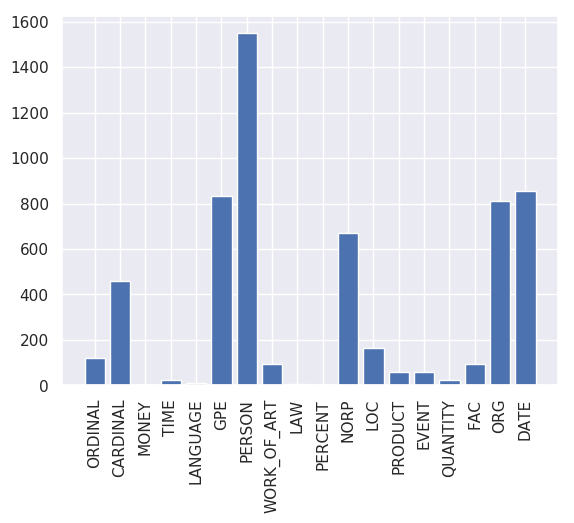

In [162]:
# Count each type
type_count = []
types_list = list(types)
for some_type in types_list: 
    type_count.append(len(type_ent[some_type]))
    
plt.bar(types_list, type_count)
plt.xticks(rotation=90)

The most frequent type of entity is PERSON, and ORG, DATE, GPE, and NORP follows, suggesting that the descriptions of collections in the Art Institute of Chiacgo are mainly documenting cultural and historical content. 

In [180]:
# calculate the precision, recall, and F-measures of the 'PERSON' category.
real = [1, 1, 0, 0, 1, 1, 1]
person_list = []
for i in range(0, 2): 
#     print(art_chicago['description_text'][i])
    entry = art_chicago['classified_sents'][i]
    for sentence in entry: 
        for entity in sentence: 
            if entity[1] == 'PERSON': 
                person_list.append(entity[0])
print(person_list)
predict = [not label is None for label in person_list] + [0]
print(sklearn.metrics.precision_score(real, predict, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(real, predict, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(real, predict, average = 'weighted')) #F-1 measure
# The prediction on the first paragraph is reliable. 

['Georges Seurat', 'Seurat', 'La Grande Jatte—1884', 'La Grande Jatte', 'Edward Hopper', 'Jo Hopper']
0.47619047619047616
0.5714285714285714
0.5194805194805194


## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here](http://universaldependencies.org/u/overview/syntax.html). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [87]:
from spacy import displacy

In [88]:
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

In [89]:
displacy.render(doc, style='dep')

In [90]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
manufacturers manufacturers pobj toward


spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

Text: The original token text.

Dep: The syntactic relation connecting child to head.

Head text: The original text of the token head.

Head POS: The part-of-speech tag of the token head.

Children: The immediate syntactic dependents of the token.

In [91]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Autonomous amod cars NOUN []
cars nsubj shift VERB [Autonomous]
shift ROOT shift VERB [cars, liability]
insurance compound liability NOUN []
liability dobj shift VERB [insurance, toward]
toward prep liability NOUN [manufacturers]
manufacturers pobj toward ADP []


Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [92]:
from spacy.symbols import nsubj, VERB

In [93]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


You can *also* navigate from above. It isn't as efficient though.

In [94]:
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break

In [95]:
print(verbs)

[shift]


### Iterating around the local tree
A few more convenience attributes are provided for iterating around the local tree from the token. Token.lefts and Token.rights attributes provide sequences of syntactic children that occur before and after the token. Both sequences are in sentence order. There are also two integer-typed attributes, Token.n_lefts and Token.n_rights that give the number of left and right children.

In [96]:
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

['bright', 'red']
['on']
2
1


You can get a whole phrase by its syntactic head using the Token.subtree attribute. This returns an ordered sequence of tokens. You can walk up the tree with the Token.ancestors attribute, and check dominance with Token.is_ancestor

In [97]:
doc = nlp("Credit and mortgage account holders must submit their requests")

root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

Credit nmod 0 2 ['account', 'holders', 'submit']
and cc 0 0 ['Credit', 'account', 'holders', 'submit']
mortgage conj 0 0 ['Credit', 'account', 'holders', 'submit']
account compound 1 0 ['holders', 'submit']
holders nsubj 1 0 ['submit']


Finally, the .left_edge and .right_edge attributes can be especially useful, because they give you the first and last token of the subtree. This is the easiest way to create a Span object for a syntactic phrase. Note that .right_edge gives a token within the subtree — so if you use it as the end-point of a range, don’t forget to +1!

In [98]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

Credit and mortgage account holders NOUN nsubj submit
must VERB aux submit
submit VERB ROOT submit
their DET poss requests
requests NOUN dobj submit


In [99]:
displacy.render(doc, style='dep')

### Information Extraction

How can dependancy graphs be useful? We can extract information from the sentences based on relationships between words within parsed phrases. Let us see if we can do this to glean any information, from, say, our movies dataset. 

How violent are the movies? Who is killing who?

In [100]:
movie_violences = {}

In [101]:
for index, row in movie_df.iterrows():
    text = ' '.join(row['Tokenized Texts'])
    movie_violences[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                movie_violences[row['Movie Name']][0].append(subject)
            if object_ is not 0:
                movie_violences[row['Movie Name']][1].append(object_)

In [102]:
movie_violences

{'#Lucky Number': (['I', "'s", 'They'],
  ['someone', 'you', 'you', 'bitch', 'son', 'celebrities', 'me', 'him']),
 "'Doc'": (['I', 'you', 'I', 'he'],
  ['them', 'people', 'Hmm', 'you', 'him', 'him', 'John', 'you']),
 '10 Items or Less': ([], []),
 '1066': (['it', 'They'],
  ['him', 'him', 'you', 'LAUGHTER', 'them', 'Ozouf', 'me', 'you']),
 '1984': (['I'], ['her']),
 '2 Hours': ([], []),
 '20 Most Awesomely Bad Songs of 2004': ([], []),
 '200 American': ([], ['them']),
 '30 Days of Night: Dark Days': ([], ['it']),
 '31 North 62 East': (['Assad'], ['them', 'them', 'women', 'civilians']),
 '500 Days of Summer': ([], []),
 '8 Mile': (["tryin'_to"], ['him', 'ya', 'somebody']),
 '9 Songs': (['you'], ['me']),
 '95ers: Echoes': ([], ['me', 'overload', 'you', 'approach', 'you']),
 'A Better Way to Die': (['I', 'you', 'You'],
  ['him', 'job', 'him', 'boy', 'me', 'him', 'anyone', 'me', 'Adder', 'me']),
 'A Blade in the Dark': (['I'], ['you', 'you', 'me', 'us', 'them']),
 'A Lot Like Love': ([], [

That's pretty neat: we can see who tried to kill who, or at least talked about it. A lot of 'I' killing 'you', as we'd imagine. What else can we see?

The movie, about time, which is about time travel, funnily enough has:
`'About Time': (['I'], ['Hitler'])`

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

In [181]:
from spacy import displacy

In [206]:
sents = art_chicago['description_text'][0].split('. ')

In [207]:
for sent in sents: 
    doc = nlp(sent)
    displacy.render(doc, style='dep')
    

# The phrase structures of the first five descriptions are complicatedly nested. 
# It turns out that parse depth is highly related to perceived sentence complexity. 
# Museum language, despite of being rigorous and highly refined, are somewhat difficult to read and understand. 
# Complexicity of museum language can be beneficial in terms of accurately documenting the 
# collections, it can sometimes put on difficulty on human to read it. 

In [212]:
# # Now analyze all the sentences in the first piece of description together. 
# sent = art_chicago['description_text'][0]
# doc = nlp(sent)

In [216]:
# Print all the noun chunks
for sent in sents: 
    print()
    doc = nlp(sent)
    for chunk in doc.noun_chunks:
        print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

# Each sentence has several noun chunks. 


“Bedlam,” “scandal scandal nsubj were
“hilarity hilarity conj scandal
the epithets epithets pobj among
what what nsubjpass considered
Georges Seurat Seurat nsubj ’s
the most remarkable paintings paintings pobj of
the nineteenth century century pobj of
it it nsubjpass exhibited
Paris Paris pobj in

Seurat Seurat nsubj labored
A Sunday Sunday pobj over
La Grande Grande pobj on
numerous preliminary drawings drawings dobj completing
oil sketches sketches conj drawings
the Art Institute Institute nsubj has
one such sketch sketch dobj has
two drawings drawings conj sketch

what what nsubj resembles
scientific precision precision dobj resembles
the artist artist nsubj tackled
the issues issues dobj tackled
color color pobj of
light light conj color
form form conj light

research research pobj by
optical and color theory theory pobj in
he he nsubj juxtaposed
tiny dabs dabs dobj juxtaposed
colors colors pobj of
optical blending blending pobj through
he he nsubj believed

the experience experie

In [217]:
# Print all tokens with their children. 
for sent in sents: 
    print()
    doc = nlp(sent)
    for token in doc:
        print(token.text, token.dep_, token.head.text, token.head.pos_,
                [child for child in token.children])


“ punct scandal NOUN []
Bedlam nmod scandal NOUN []
, punct scandal NOUN []
” punct scandal NOUN []
“ punct scandal NOUN []
scandal nsubj were AUX [“, Bedlam, ,, ”, “, ,, ”, and, hilarity]
, punct scandal NOUN []
” punct scandal NOUN []
and cc scandal NOUN []
“ punct hilarity NOUN []
hilarity conj scandal NOUN [“, ”]
” punct hilarity NOUN []
were ROOT were AUX [scandal, among, ,, and, one]
among prep were AUX [epithets]
the det epithets NOUN []
epithets pobj among ADP [the, used]
used acl epithets NOUN [describe]
to aux describe VERB []
describe xcomp used VERB [to, considered]
what nsubjpass considered VERB []
is auxpass considered VERB []
now advmod considered VERB []
considered ccomp describe VERB [what, is, now, ’s, work]
Georges compound Seurat PROPN []
Seurat nsubj ’s PART [Georges]
’s ccomp considered VERB [Seurat]
greatest amod work NOUN []
work oprd considered VERB [greatest]
, punct were AUX []
and cc were AUX []
one conj were AUX [of, ,, exhibited]
of prep one NUM [painting

In [224]:
# What are the VERBs that are associated with a nominal subject? 
from spacy.symbols import nsubj, VERB
verbs = []
for sent in sents: 
    doc = nlp(sent)
    for possible_verb in doc:
        if possible_verb.pos == VERB:
            for possible_subject in possible_verb.children:
                if possible_subject.dep == nsubj:
                    verbs.append(possible_verb)

In [225]:
verbs

[labored,
 resembles,
 tackled,
 juxtaposed,
 form,
 believed,
 surrounded,
 enclosed,
 cast,
 makes,
 continues]

In [262]:
# What are the VERBs that are associated with a noun phrase which is the syntactic subject of a passive clause? 
from spacy.symbols import nsubjpass, VERB
candidate = []
for sent in sents: 
    doc = nlp(sent)
    for possible1 in doc:
        if possible1.pos == VERB:
#             if possible.text == 'exhibited': 
#                 print([(token, token.dep==nsubjpass) for token in possible.children])
            for possible2 in possible1.children:
                if possible2.dep == nsubjpass:
                    candidate.append(possible1)
candidate

[considered, exhibited, exhibited]

In [255]:
?spacy.symbols

In [263]:
# What are the ADJs that are associated with an adverbial modifier ? 
from spacy.symbols import advmod, ADJ
candidate = []
for sent in sents: 
    doc = nlp(sent)
    for possible1 in doc:
        if possible1.pos == ADJ:
            for possible2 in possible1.children:
                if possible2.dep == advmod:
                    candidate.append((possible1, possible2))
candidate

[(remarkable, most),
 (luminous, brilliantly),
 (intense, more),
 (silent, forever)]

In [264]:
# What are the ADVs that are associated with an adverbial modifier ? 
from spacy.symbols import advmod, ADV
candidate = []
for sent in sents: 
    doc = nlp(sent)
    for possible1 in doc:
        if possible1.pos == ADV:
            for possible2 in possible1.children:
                if possible2.dep == advmod:
                    candidate.append((possible1, possible2))
candidate

[(brilliantly, more), (more, even)]

In [265]:
# What are the VERBs that are associated with a object ? 
from spacy.symbols import dobj, VERB
candidate = []
for sent in sents: 
    doc = nlp(sent)
    for possible1 in doc:
        if possible1.pos == VERB:
            for possible2 in possible1.children:
                if possible2.dep == dobj:
                    candidate.append((possible1, possible2))
candidate

[(reworking, original),
 (completing, drawings),
 (resembles, precision),
 (tackled, issues),
 (juxtaposed, dabs),
 (form, single),
 (surrounded, canvas),
 (enclosed, which)]

In [267]:
art_chicago.head(10)

,artwork_title,description_text,index,url,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,sentences,POS_sents,classified_sents
0,"A Sunday on La Grande Jatte — 1884, 1884/86, G...","“Bedlam,” “scandal,” and “hilarity” were among...",0.0,https://www.artic.edu/artworks/27992/a-sunday-...,"[Bedlam, scandal, and, hilarity, were, among, ...",188,"[bedlam, scandal, hilarity, epithet, describe,...",98,"[(“, ``), (bedlam, NNP), (,, ,), (”, ''), (“, ...","[[Bedlam, scandal, and, hilarity, were, among,...","[[(Bedlam, NNP), (scandal, NN), (and, CC), (hi...","[[(Bedlam, ORG), (Georges Seurat, PERSON), (on..."
1,"Nighthawks, 1942, Edward Hopper",Edward Hopper said that Nighthawks was inspire...,1.0,https://www.artic.edu/artworks/111628/nighthawks,"[Edward, Hopper, said, that, Nighthawks, was, ...",215,"[edward, hopper, say, nighthawks, inspire, res...",110,"[(edward, NNP), (hopper, NNP), (said, VBD), (t...","[[Edward, Hopper, said, that, Nighthawks, was,...","[[(Edward, NNP), (Hopper, NNP), (said, VBD), (...","[[(Edward Hopper, PERSON), (Nighthawks, ORG), ..."
2,"American Gothic, 1930, Grant Wood",This familiar image was exhibited publicly for...,2.0,https://www.artic.edu/artworks/6565/american-g...,"[This, familiar, image, was, exhibited, public...",243,"[familiar, image, exhibit, publicly, time, art...",120,"[(this, DT), (familiar, JJ), (image, NN), (was...","[[This, familiar, image, was, exhibited, publi...","[[(This, DT), (familiar, JJ), (image, NN), (wa...","[[(first, ORDINAL), (the Art Institute of Chic..."
3,"The Bedroom, 1889, Vincent van Gogh",Vincent van Gogh so highly esteemed his bedroo...,3.0,https://www.artic.edu/artworks/28560/the-bedroom,"[Vincent, van, Gogh, so, highly, esteemed, his...",266,"[vincent, van, gogh, highly, esteem, bedroom, ...",134,"[(vincent, NNP), (van, NNP), (gogh, NNP), (so,...","[[Vincent, van, Gogh, so, highly, esteemed, hi...","[[(Vincent, NNP), (van, NNP), (Gogh, NNP), (so...","[[(Vincent van Gogh, PERSON), (three, CARDINAL..."
4,"Nightlife, 1943, Archibald John Motley Jr.",Chicago painter Archibald Motley represented t...,4.0,https://www.artic.edu/artworks/117266/nightlife,"[Chicago, painter, Archibald, Motley, represen...",212,"[chicago, painter, archibald, motley, represen...",119,"[(chicago, NNP), (painter, NNP), (archibald, N...","[[Chicago, painter, Archibald, Motley, represe...","[[(Chicago, NNP), (painter, NN), (Archibald, N...","[[(Chicago, GPE), (Archibald Motley, PERSON), ..."
5,"The Old Guitarist, late 1903–early 1904, Pablo...","Pablo Picasso produced The Old Guitarist, one ...",5.0,https://www.artic.edu/artworks/28067/the-old-g...,"[Pablo, Picasso, produced, The, Old, Guitarist...",190,"[pablo, picasso, produce, old, guitarist, haun...",99,"[(pablo, NNP), (picasso, NNP), (produced, VBD)...","[[Pablo, Picasso, produced, The, Old, Guitaris...","[[(Pablo, NNP), (Picasso, NNP), (produced, VBD...","[[(Pablo Picasso, PERSON), (Barcelona, GPE), (..."
6,"Paris Street; Rainy Day, 1877, Gustave Cailleb...","This complex intersection, just minutes away f...",6.0,https://www.artic.edu/artworks/20684/paris-str...,"[This, complex, intersection, just, minutes, a...",198,"[complex, intersection, minute, away, saint, l...",122,"[(this, DT), (complex, JJ), (intersection, NN)...","[[This, complex, intersection, just, minutes, ...","[[(This, DT), (complex, JJ), (intersection, NN...","[[(just minutes, TIME), (Saint Lazare, FAC)], ..."
7,Buddha Shakyamuni Seated in Meditation (Dhyana...,This meditating Buddha comes from the coastal ...,7.0,https://www.artic.edu/artworks/21023/buddha-sh...,"[This, meditating, Buddha, comes, from, the, c...",135,"[meditate, buddha, come, coastal, town, nagapa...",69,"[(this, DT), (meditating, VBG), (buddha, NN), ...","[[This, meditating, Buddha, comes, from, the, ...","[[(This, DT), (meditating, VBG), (Buddha, NNP)...","[[(Buddha, PERSON), (Nagapattinam, ORG), (Indi..."
8,"The Assumption of the Virgin, 1577–79, Domenic...",This paint

In [285]:
# Extracting information from museum language

# Let's see what artists present or what is presented by others: 

info = {}
for index, row in art_chicago.iterrows():
    text = ' '.join(row['tokenized_text'])
    info[row['artwork_title']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'present' or chunk.root.head.text == 'presents' or chunk.root.head.text == 'presented':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                info[row['artwork_title']][0].append(subject)
            if object_ is not 0:
                info[row['artwork_title']][1].append(object_)

In [292]:
for title in info.keys(): 
    if info[title][0] or info[title][1]:  # check whether the lists are empty. 
        print(info[title])

(['Picasso'], ['Guitarist'])
([], ['him'])
([], ['museum'])
([], ['subtleties'])
([], ['analogy'])
(['female'], [])
([], ['subject'])
([], ['image'])
(['artist'], ['work'])
([], ['illusion'])
(['he'], ['figure'])
(['poet', 'poem'], ['subject'])
(['enormity'], [])
(['Arbus'], ['women'])
(['portrait'], ['Addie'])
([], ['him'])
(['scene'], ['theme'])
([], ['painting'])
(['Winter'], ['Saturn'])
(['pioneer'], ['aesthetic', 'culture'])
(['textile'], ['sense'])
(['pioneer'], ['aesthetic', 'culture'])


# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the: 

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$. 

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [103]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

,download_url,html_url,name,path,text
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...


Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [104]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [105]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

114

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [106]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

1.0

We can now compute the KL divergence. Pay attention to the asymmetry. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want symmetry.

In [107]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.632804454460187
0.5784905983449496


Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [108]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

,word,elementwise divergence
0,important,0.000477
1,regular,0.000055
2,start,0.000055
3,introduce,0.000073
4,pass,0.000064
5,fully,0.000818
6,urge,0.000477
7,august,0.000073
8,society,0.002129
9,pende,0.000073


In [109]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

,word,elementwise divergence
172,iraq,0.094839
228,bush,0.048099
292,american,0.025871
66,stem,0.023705
207,law,0.022781
37,department,0.019537
212,member,0.013240
92,war,0.012655
61,program,0.011213
57,country,0.010187


Now we will apply what we learned today 
First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed.
We'll use only the first 11 movies: you are welcome to try more.

In [110]:
corpora = []
for index, row in movie_df.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['Tokenized Texts'])

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [111]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

Define some covenient funtions for calculating divergence and distances.

In [112]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$. Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text. Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal. The same is true for the $\chi^2$ divergence.

In [113]:
len(corpora)

11

In [114]:
fileids = list(movie_df['Movie Name'])[0:11]

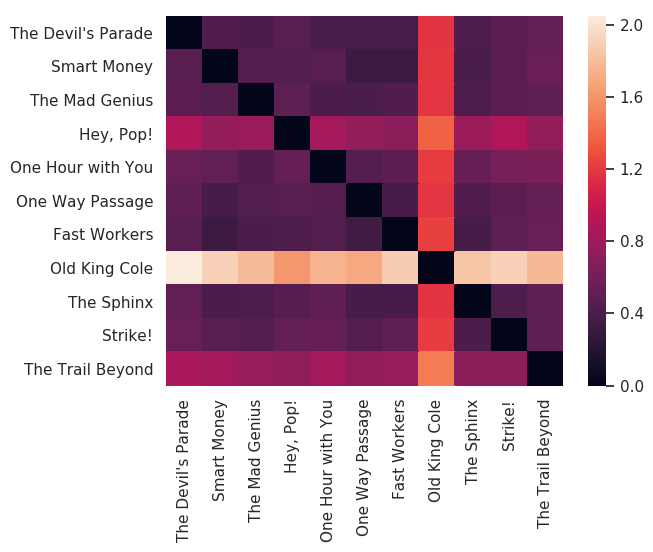

In [115]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()


To reveal more patterns, let's do a multidimensional scaling of the matrix.

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


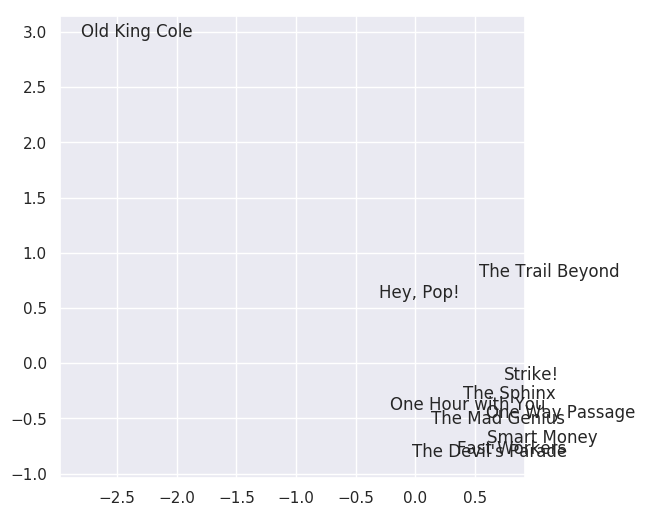

In [116]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

A co-respondent's course and The Chain Gang are away from the others - any guesses why?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

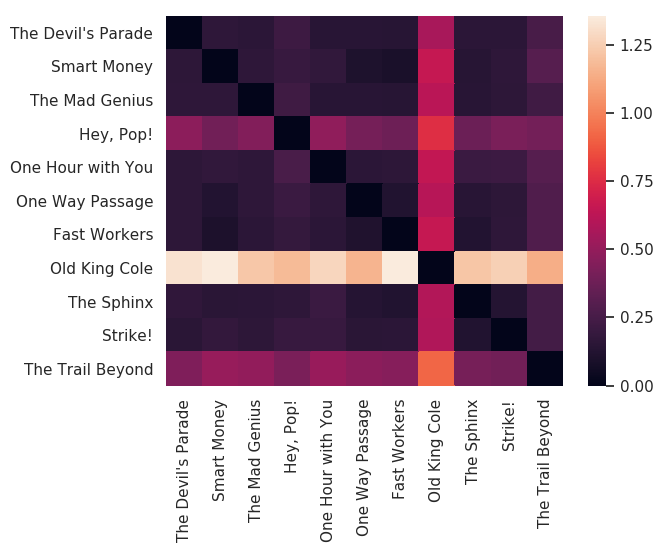

In [117]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

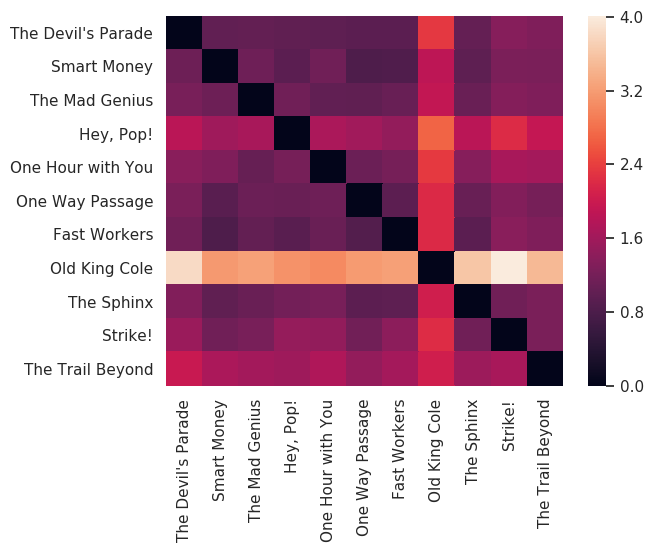

In [118]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

Now we compute the same for the assymmetric $\chi^2$ Divergence.

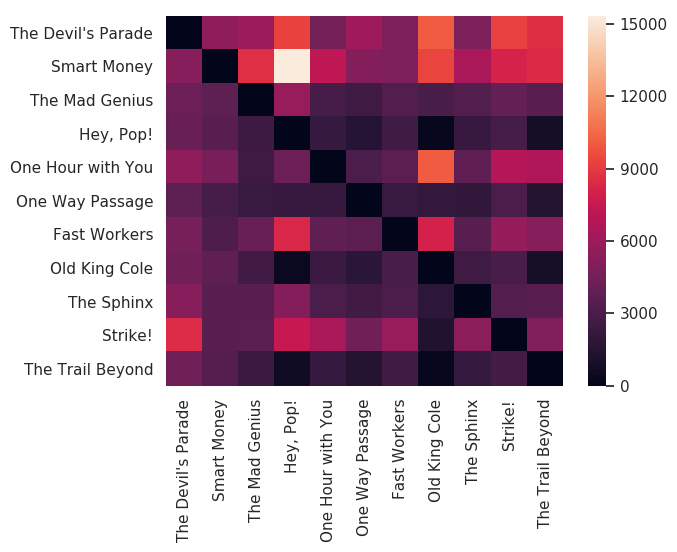

In [119]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

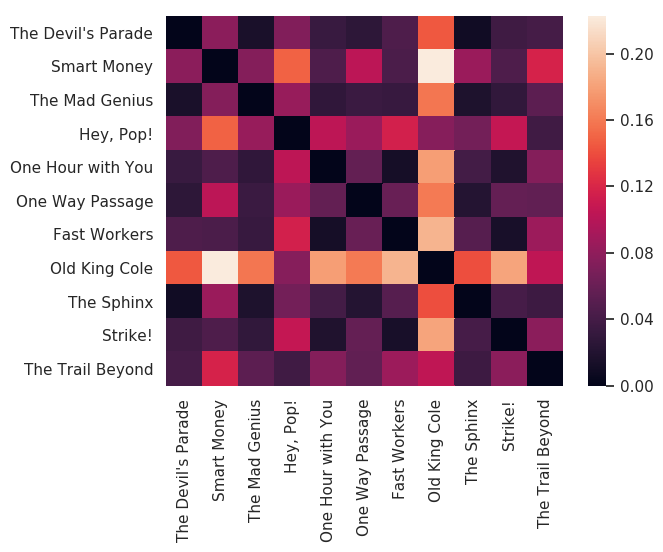

In [120]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

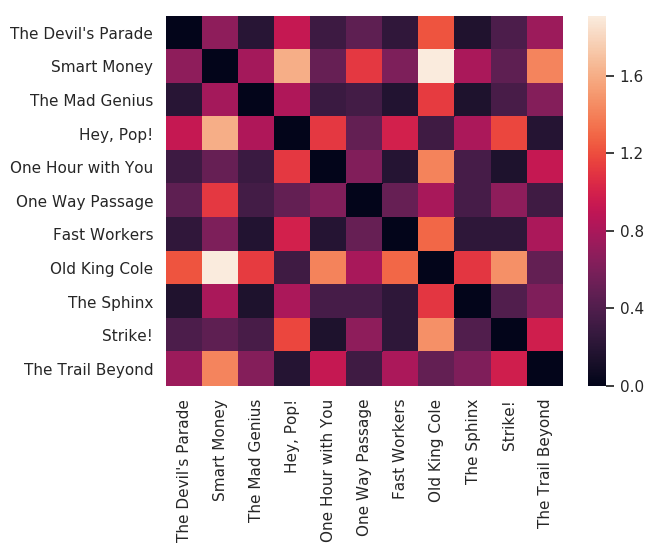

In [121]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

You can see that decade X is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier.

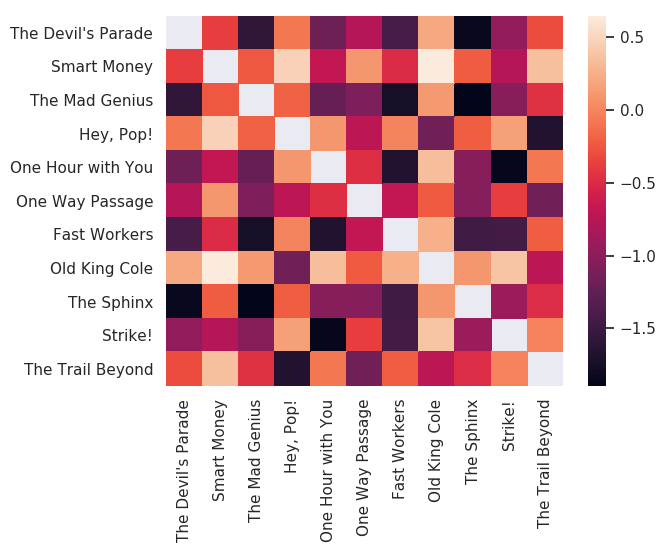

In [122]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

We only tried 11 movies, and from the same time period, so our signals might not be too interesting. What about different time periods?

An interesting experiment to maybe get some clearer signals: documents by decade in the Davies Corpus Of Historial American English (COHA) and see if we can detect patterns between them. 

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example: 

In [123]:
shakespeare_df = lucem_illud_2020.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [124]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normalizeTokens(x))

Create the corpus file and generate the heatmap:

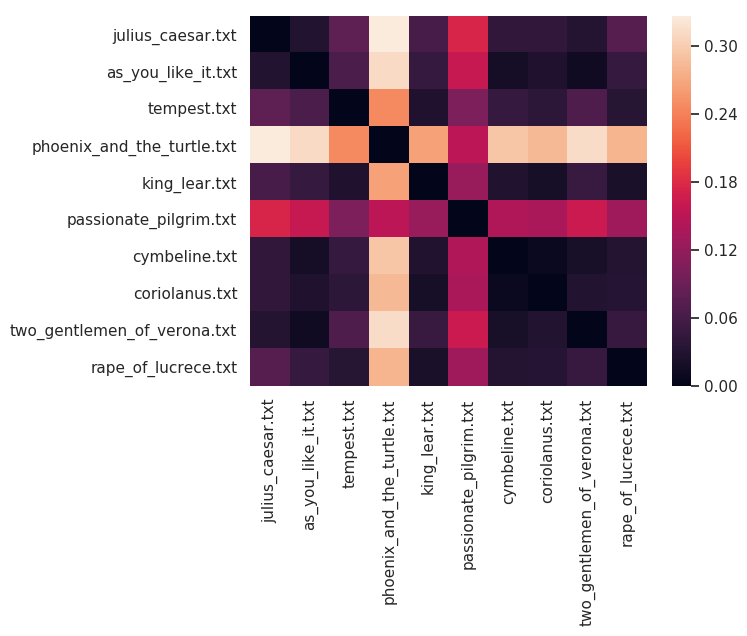

In [125]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <span style="color:red">*Exercise 6*</span>

<span style="color:red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

<span style="color:red">**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 

In [297]:
# Investigate the pair-wise divergences among the first artworks
corpora = []
for index, row in art_chicago.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['tokenized_text'])

In [298]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

In [299]:
# Define some covenient funtions for calculating divergence and distances.
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [303]:
fileids = list(art_chicago['artwork_title'])[0:len(corpora)]

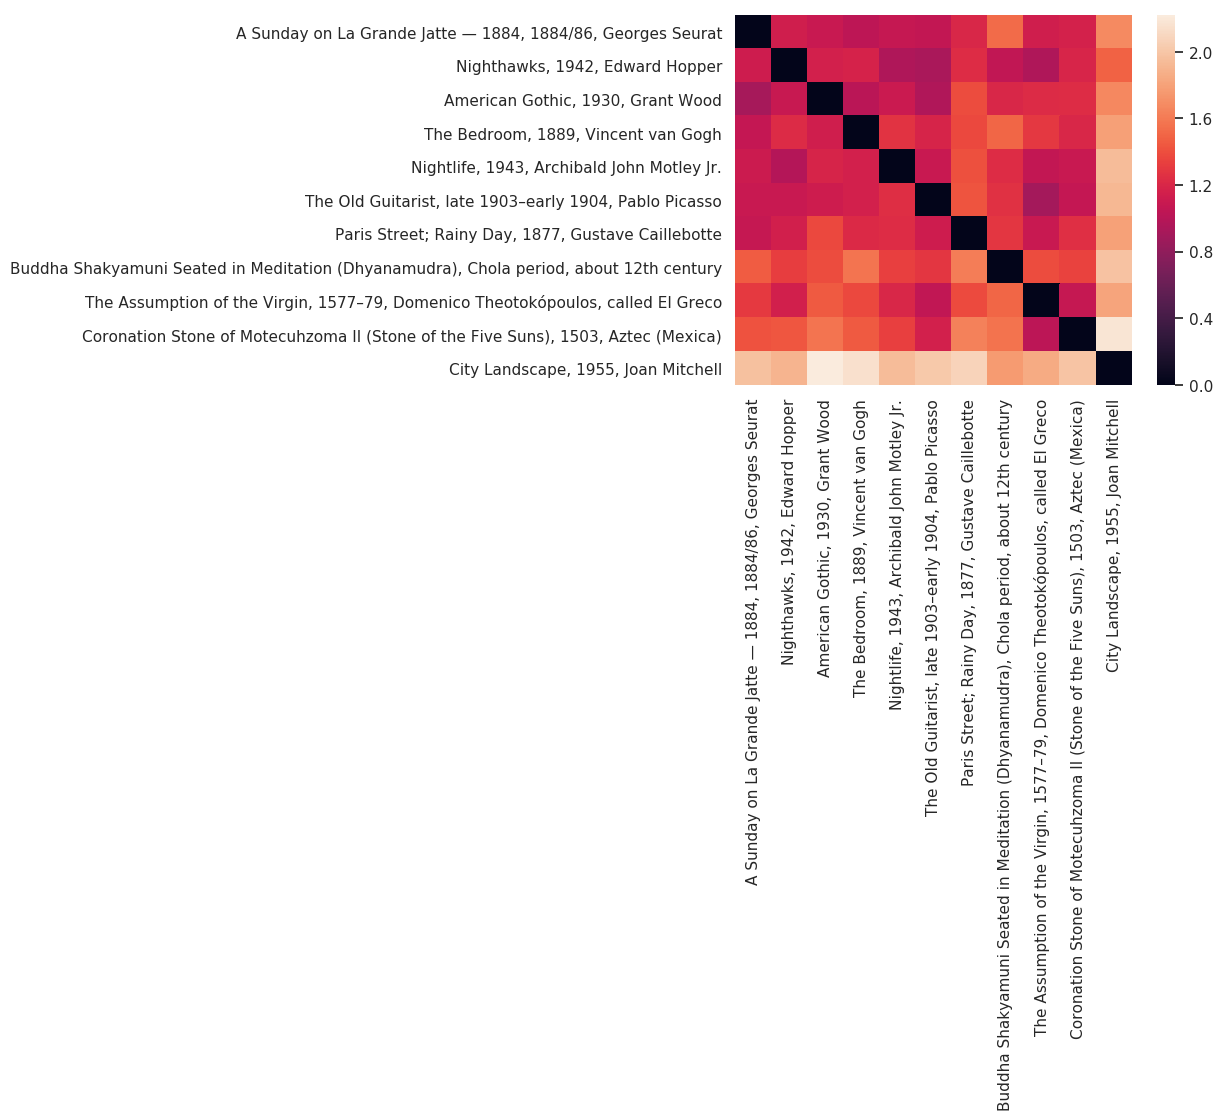

In [304]:
# calculate the KL divergence for each pair of corpora, 
# turn the results into a matrix, and visualize the matrix as a heatmap. 
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


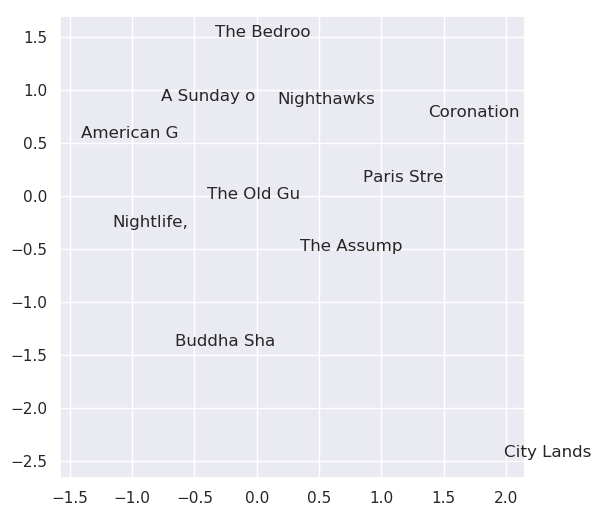

In [313]:
# Perform a multidimensional scaling of the matrix to reveal more patterns. 
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt[:10], (x[i],y[i]))
    
    
# The titles are truncated to save place

# City Landscape is slightly divergent from others. 

In [321]:
art_chicago[art_chicago['artwork_title'] == 'City Landscape, 1955, Joan Mitchell']['description_text'][10]

'Although influenced by Abstract Expressionist artists in New York in the early 1950s, Joan Mitchell did not prioritize self-expression: her often exuberant abstractions were “about landscape, not about me,” she once explained. Mitchell painted large, light-filled canvases animated by loosely applied skeins of bright color—here infused with the energy of a large metropolis.'

In [322]:
art_chicago[art_chicago['artwork_title'] == 'City Landscape, 1955, Joan Mitchell']['description_text'][11]

'The title suggests a relationship between the painting’s network of pigments and the nerves or arteries of an urban space. The sense of spontaneity conveyed in City Landscape, however, belies Mitchell’s methods. Unlike many of her contemporaries, who were dubbed “action painters,” Mitchell worked slowly and deliberately. “I paint a little,” she said. “Then I sit and look at the painting, sometimes for hours. Eventually, the painting tells me what to do.”'

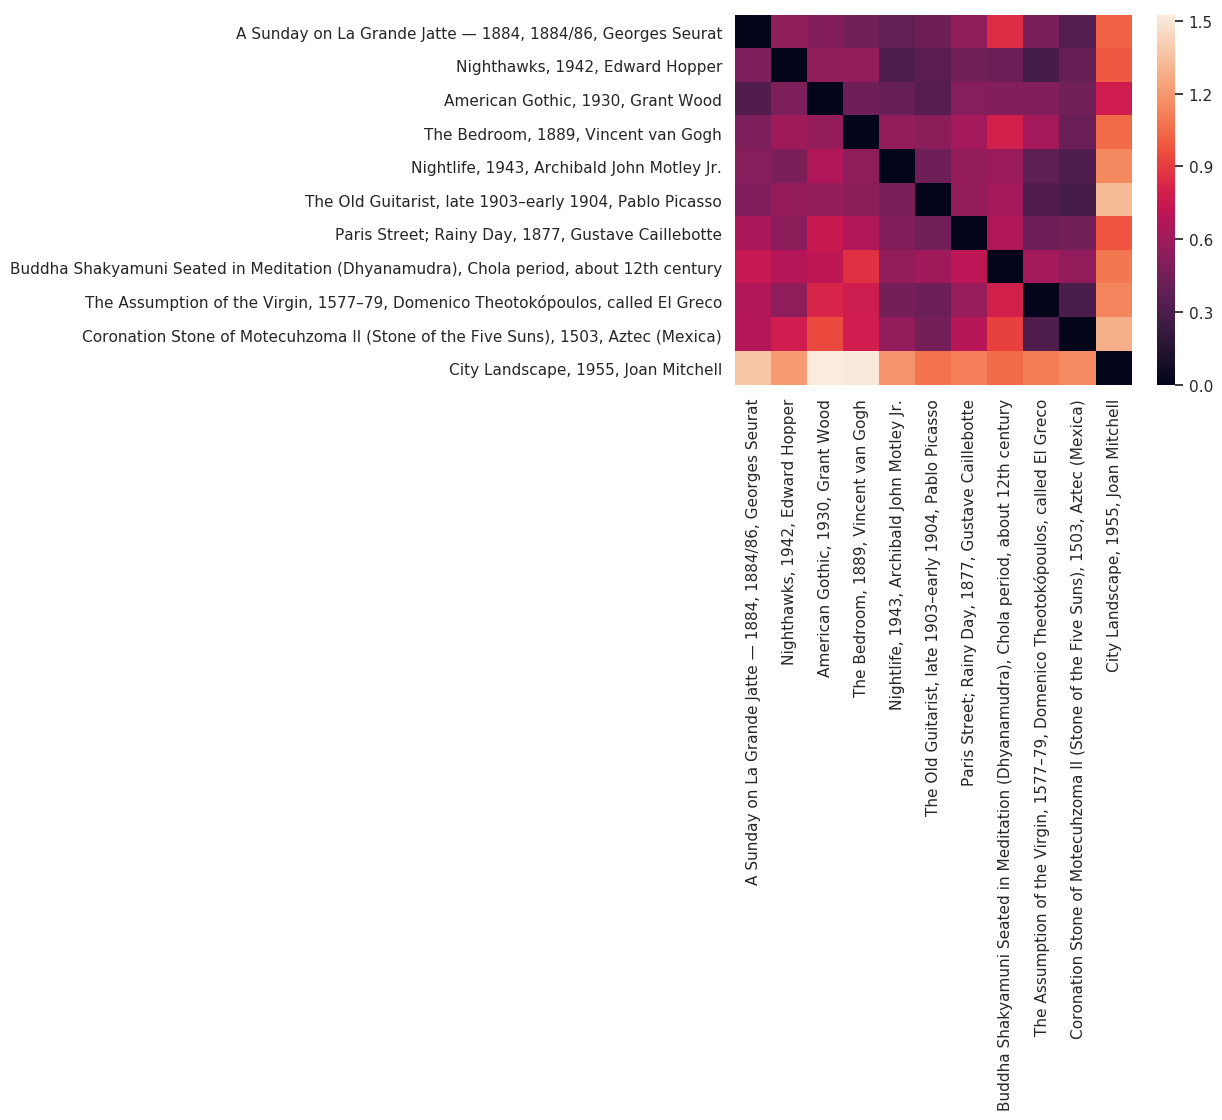

In [323]:
# do the analysis again first for stopwords
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2544: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


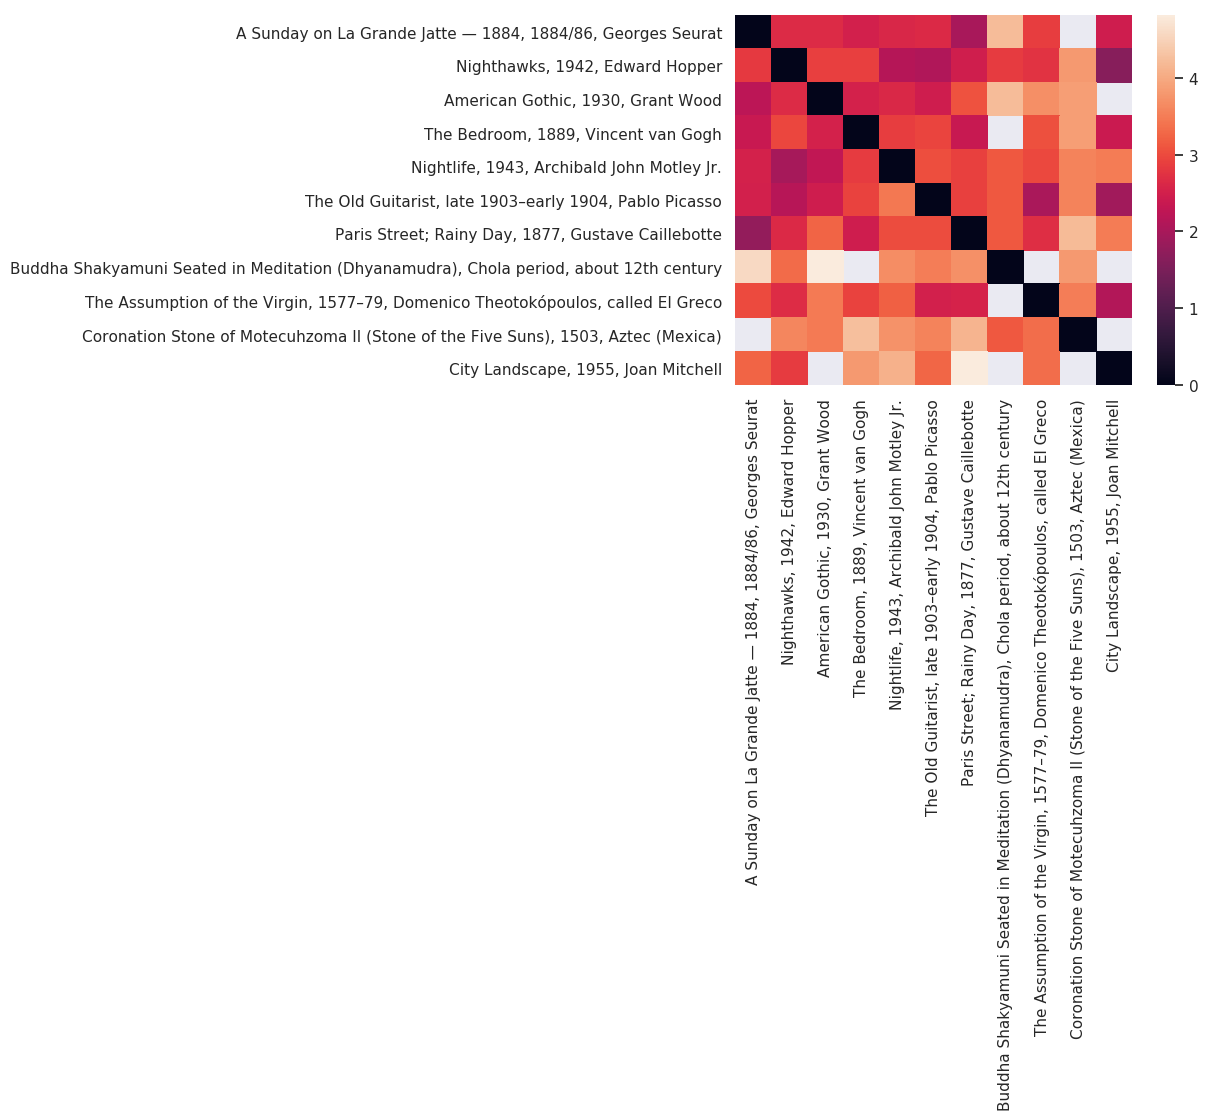

In [324]:
# do the analysis again first for non-stopwords
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

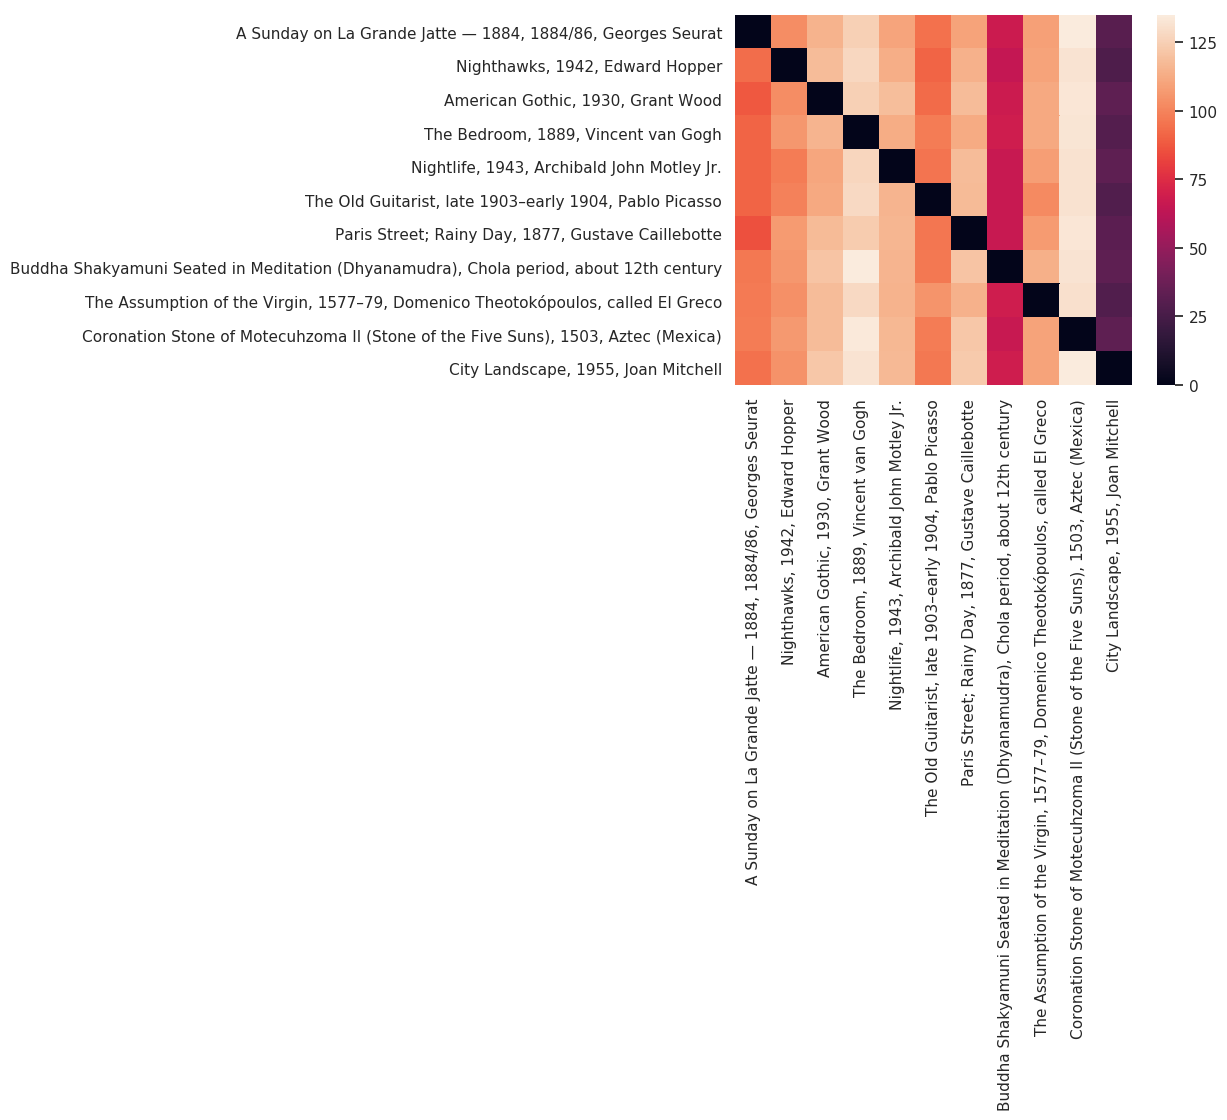

In [325]:
# do the analysis again first for non-stopwords using chi-squared divergence
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

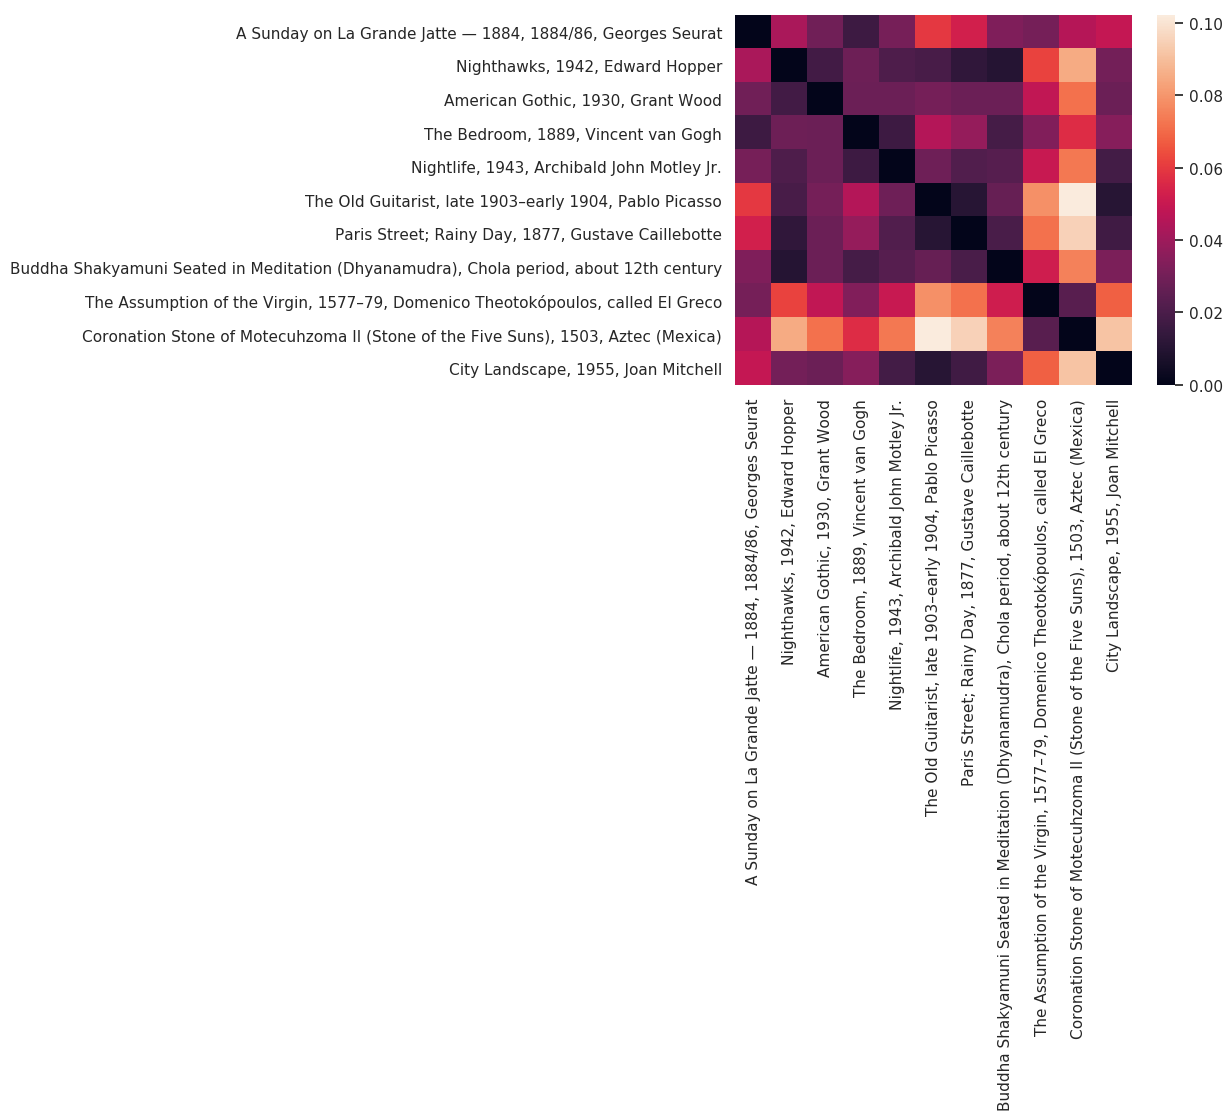

In [327]:
# do the analysis again first for non-stopwords using KS distance
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

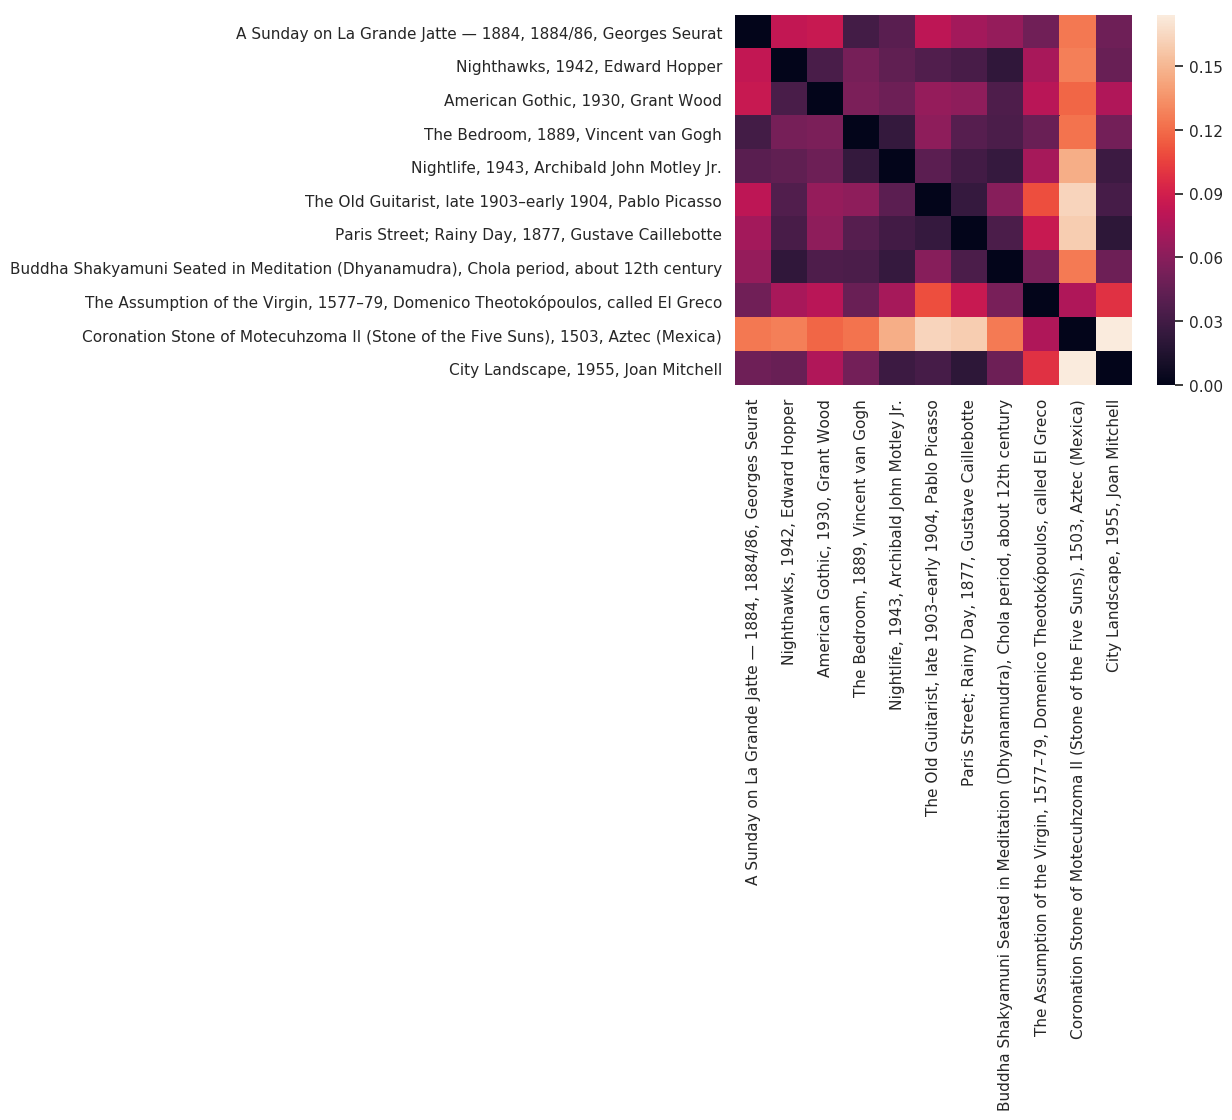

In [328]:
# do the analysis again first for non-stopwords using Wasserstein divergence
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

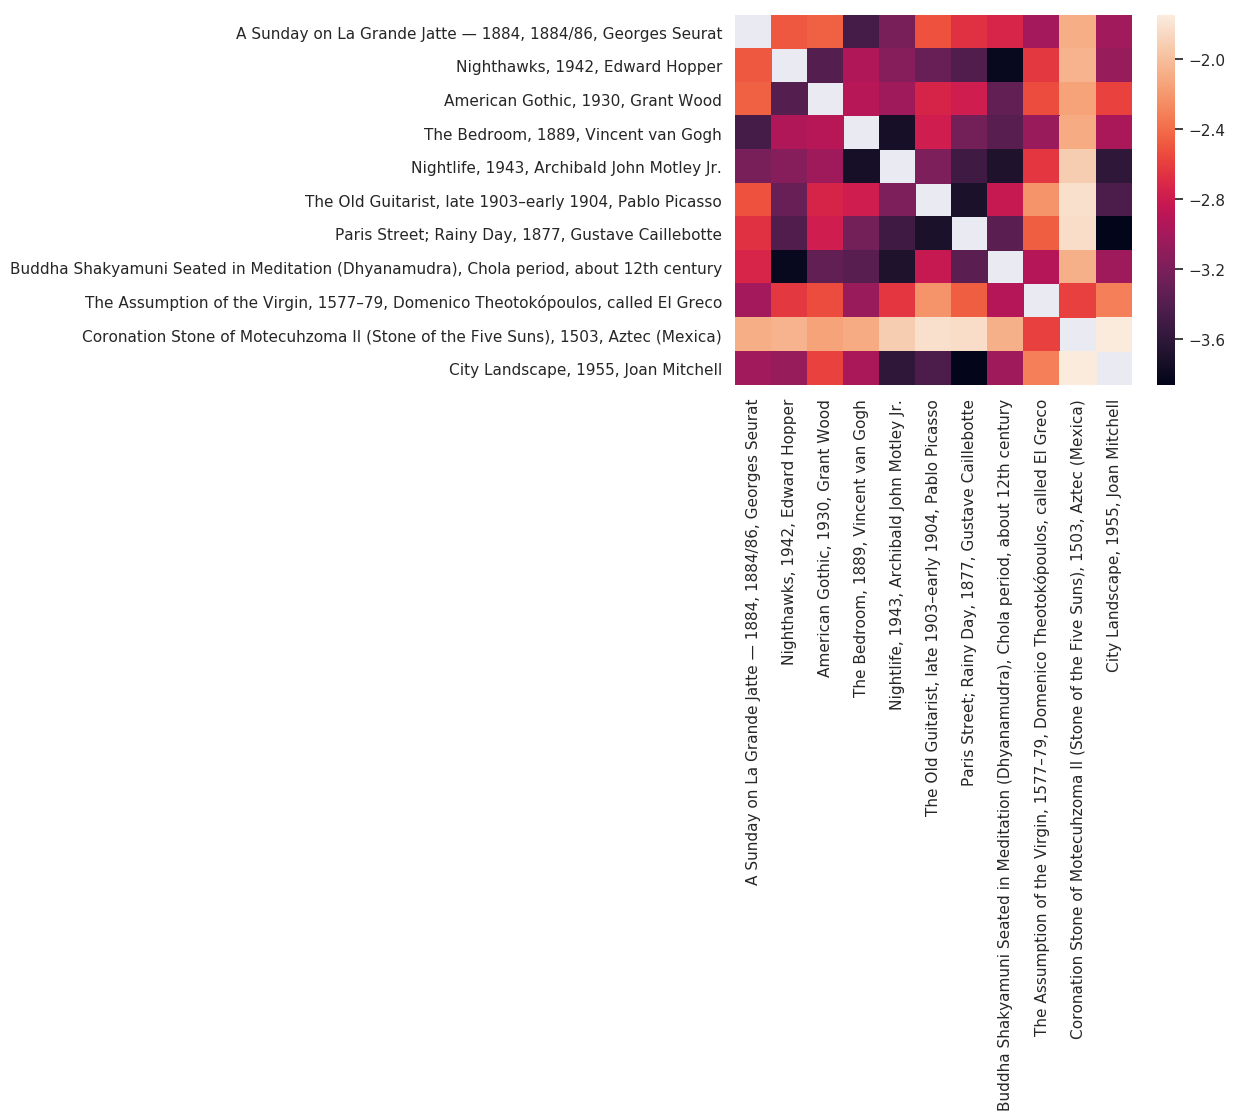

In [329]:
# taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier.
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

In [330]:
# Museum language is rich enough to make every description distinct from each other. 
# Since the script of museum documentation usually underwent serious refinement and
# careful investigation and can be done by the same team, the style and vocabulary 
# are not significantly converging among different pieces of descriptions. However, 
# since the length of paragraph is short and each artwork has tramendously differently 
# historical and cultural background to be introduced, the corpus can be hugely divergent. 

# A more interesting question to look into is that, is there any divergence between descriptions
# that are written for artpieces from different countries, or different cultures? This 
# analysis can be done when the corpus has been completely retrieved. Now the spidering is
# still going on, since the Art Institute of Chicago set a limitation on the highest 
# frequency of visiting their website. 